<a href="https://colab.research.google.com/github/Saran-nns/traja-research/blob/master/ForecastingJaguarLSTMCategoricalAE3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone https://github.com/traja-team/traja.git
# !cd traja && git checkout NeuralNetworks
# !wget justinshenk.com/share/E1_E2.csv
!git clone https://github.com/traja-team/traja-research.git
!cd traja-research && git checkout dataset_und_notebooks

Cloning into 'traja-research'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 305 (delta 85), reused 257 (delta 46), pack-reused 0
Receiving objects: 100% (305/305), 20.29 MiB | 24.65 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Branch 'dataset_und_notebooks' set up to track remote branch 'dataset_und_notebooks' from 'origin'.
Switched to a new branch 'dataset_und_notebooks'


In [ ]:
# import sys; sys.path.append('./traja')
# import traja
from random import randint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Plot defaults

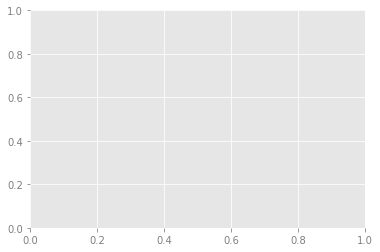

In [ ]:
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.ticklabel_format(useOffset=False)

### Data preprocessing

#### Data

In [ ]:
# trjs = pd.read_csv("E1_E2.csv")
# trjs.dropna(subset=['x','y'],inplace=True)
# axes = ['x', 'y', 'hour', 'day', 'ID']
# trjs = trjs.filter(items=axes).replace(['E1', 'E2'], [0, 1])
# trjs = trjs[['x','y']][:50000]

In [ ]:
trjs = pd.read_csv('./traja-research/dataset_analysis/jaguar117/jaguar_movement_data.csv')
print('IDs/Animal trajectories in the dataset',trjs['individual.local.identifier (ID)'].unique())
trjs.head()

IDs/Animal trajectories in the dataset [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Event_ID      timestamp  ...   study.name   country
0       1.0  6/15/10 22:43  ...  Humid Chaco  Paraguay
1       2.0   6/16/10 2:52  ...  Humid Chaco  Paraguay
2       3.0  6/16/10 22:36  ...  Humid Chaco  Paraguay
3       4.0  6/17/10 16:42  ...  Humid Chaco  Paraguay
4       5.0  6/17/10 20:37  ...  Humid Chaco  Paraguay

[5 rows x 9 columns]

In [ ]:
# Filter IDs, Latitude and longitude columns and rename them 
dataset_traj = trjs[['location.long','location.lat','individual.local.identifier (ID)']]
# IDs = list(range(10))
IDs = list(range(10))
dataset_traj_ = dataset_traj[dataset_traj['individual.local.identifier (ID)'].isin(IDs)]
dataset_traj_['individual.local.identifier (ID)'].unique()
dataset_traj_ = dataset_traj_.rename(columns={"individual.local.identifier (ID)": "ID","location.long":"x", 
                                              "location.lat":"y"})
dataset_traj_

x          y  ID
0    -58.030128 -23.326947   1
1    -58.030643 -23.328427   1
2    -58.030472 -23.327311   1
3    -58.027983 -23.309952   1
4    -58.027747 -23.310006   1
...         ...        ...  ..
4523 -58.042836 -23.325394   9
4524 -58.042143 -23.328108   9
4525 -58.042966 -23.326331   9
4526 -58.043336 -23.326598   9
4527 -58.041257 -23.326947   9

[4528 rows x 3 columns]

#### Data Train-Test Split and Scaling

In [ ]:
def generate_dataset(df, n_past, n_future):
    """
    df : Dataframe
    n_past: Number of past observations
    n_future: Number of future observations
    Returns:
    X: Past steps
    Y: Future steps (Sequence target)
    Z: Sequence category""" 
    
    # Split the dataframe with respect to IDs
    series_ids = dict(tuple(df.groupby('ID'))) # Dict of ids as keys and x,y,id as values
    train_data, target_data, target_category = list(), list(), list()
    
    for id in series_ids.keys():
        X, Y, Z= list(), list(), list()
        # Drop the column ids and convert the pandas into arrays 
        series = series_ids[id].drop(columns = ['ID']).to_numpy() 
        for window_start in range(len(series)):
            past_end = window_start + n_past
            future_end = past_end + n_future
            if not future_end > len(series):
                # slicing the past and future parts of the window
                past, future = series[window_start:past_end, :], series[past_end:future_end, :]
                X.append(past)
                Y.append(future)
                # For each sequence length set target category
                Z.append(int(id))
                
        train_data.extend(np.array(X))
        target_data.extend(np.array(Y))
        target_category.extend(np.array(Z))

    return train_data, target_data, target_category

In [ ]:
num_past = 10
num_future = 5

train_data, target_data, target_category = generate_dataset(dataset_traj_, n_past=num_past,n_future=num_future)
print(len(train_data),len(target_data),len(target_category))# Num of classes(IDs) in the data

4402 4402 4402


#### Sample plot of train and target

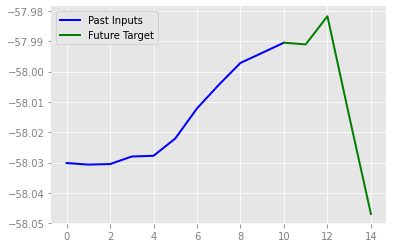

In [ ]:
from matplotlib.lines import Line2D
# Sample plot of input and target of single sequence 
# Plot all data elements in red
sample_x = list(train_data[0][:,0])
sample_y = list(target_data[0][:,0])

xy = np.array(sample_x + sample_y)
x = np.arange(len(xy))
valid,forecast = x<=len(sample_x),x>=len(sample_x)
plt.plot(x,np.ma.MaskedArray(xy,~valid),'b',x,np.ma.MaskedArray(xy,~forecast),'g')

custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='g', lw=2)]
plt.legend(custom_lines, ['Past Inputs', 'Future Target'])
plt.savefig('data')
plt.show()


##### Split data


In [ ]:
from sklearn.utils import shuffle

# Shuffle the IDs and the corresponding sequence , preserving the order
train_data, target_data, target_category = shuffle(train_data, target_data, target_category)

# Train test split
split = int(0.75*len(train_data)) 

train_x = train_data[:split]
train_y = target_data[:split]
train_z = target_category[:split]

test_x = train_data[split:]
test_y = target_data[split:]
test_z = target_category[split:]

print('Train data,target, cat',len(train_x),len(train_y),len(train_z))
print('Test data,target, cat',len(test_x),len(test_y),len(test_z))


Train data,target, cat 3301 3301 3301
Test data,target, cat 1101 1101 1101


##### Scaling the data in each batch

In [ ]:
def scale_data(data, sequence_length):
    assert len(data[0].shape)==2
    scalers={}
    data = np.vstack(data)
    
    for i in range(data.shape[1]):
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(data[:,i].reshape(-1,1))
        s_s=np.reshape(s_s,len(s_s))
        scalers['scaler_'+ str(i)] = scaler
        data[:,i]=s_s
    # Slice the data into batches
    data = [data[i:i + sequence_length] for i in range(0, len(data), sequence_length)]
    return data, scalers


(train_x, train_x_scaler),(train_y,train_y_scaler) = scale_data(train_x,sequence_length=10),scale_data(train_y,sequence_length=5)
(test_x,test_x_scaler),(test_y,test_y_scaler) = scale_data(test_x,sequence_length=10),scale_data(test_y,sequence_length=5)

print('Train data {} Target data {}'.format(train_x[0], train_y[0]))
print('Train data length {}, target data length {}, category length {}'.format(len(train_x),len(train_y),len(train_z)))
print('Test data length {}, target data length {}, category length {}'.format(len(test_x),len(test_y),len(test_z)))

Train data [[-0.7145499   0.67844203]
 [-0.71413829  0.68039537]
 [-0.71412697  0.68078604]
 [-0.717327    0.67556701]
 [-0.71736772  0.67555943]
 [-0.71810948  0.67111036]
 [-0.72261666  0.66798881]
 [-0.72264607  0.66797174]
 [-0.72253752  0.66669353]
 [-0.72183192  0.66473261]] Target data [[-0.7217957   0.66331975]
 [-0.72261216  0.6680476 ]
 [-0.72271614  0.66785226]
 [-0.72148588  0.67037264]
 [-0.7187721   0.67592165]]
Train data length 3301, target data length 3301, category length 3301
Test data length 1101, target data length 1101, category length 1101


### Pytorch dataset class

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self,data, target, category):
        self.data = data
        self.target = target
        self.category = category
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        z = self.category[index]
        return x, y,z

    def __len__(self):
        return len(self.data)

### Pytorch dataloader with random weighted sampler:
To address class imbalance. This avoid model overfit to certain IDs with large samples in the dataset

In [ ]:
# Get class distribution in the dataset
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

def get_class_distribution(targets): 
    """Compute class distribution, returns number of classes and their count in the targets"""
    targets_ = np.unique(targets, return_counts=True)
    return targets_[0],targets_[1]

# # Prepare weighted random sampler: 
# train_target_list = torch.tensor(train_z)
# test_target_list = torch.tensor(test_z)

# # Number of classes and their frequencies
# train_targets_, train_class_count = get_class_distribution(train_target_list)
# test_targets_, test_class_count = get_class_distribution(test_target_list)

# # Compute class weights
# train_class_weights = 1./torch.tensor(train_class_count, dtype=torch.float)
# test_class_weights = 1./torch.tensor(test_class_count, dtype=torch.float)

# # Assign weights to original target list
# train_class_weights_all = train_class_weights[train_target_list-1] # Note the targets start from 1, to python idx to apply,-1
# test_class_weights_all = test_class_weights[test_target_list-1]

# # Weighted samplers
# train_weighted_sampler = WeightedRandomSampler(
#     weights=train_class_weights_all,
#     num_samples=len(train_class_weights_all),
#     replacement=True
# )
# test_weighted_sampler = WeightedRandomSampler(
#     weights=test_class_weights_all,
#     num_samples=len(test_class_weights_all),
#     replacement=True
# )

# Dataset
train_dataset = TimeSeriesDataset(train_x,train_y,train_z)
test_dataset = TimeSeriesDataset(test_x,test_y,test_z)

# Dataloader with weighted samplers
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=10,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=10, drop_last=True)

print("Number of batches in the train data loader {}".format(len(train_loader)))
print("Number of batches in the test data loader {}".format(len(test_loader)))

Number of batches in the train data loader 330
Number of batches in the test data loader 110


### Model

##### Wrapper: LSTM layers with TD linear output layer

In [ ]:
class TimeDistributed(torch.nn.Module):
    """ Time distributed wrapper compatible with linear/dense pytorch layer modules"""
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        # Linear layer accept 2D input
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        out = self.module(x_reshape)

        # We have to reshape Y back to the target shape
        if self.batch_first:
            out = out.contiguous().view(x.size(0), -1, out.size(-1))  # (samples, timesteps, output_size)
        else:
            out = out.view(-1, x.size(1), out.size(-1))  # (timesteps, samples, output_size)

        return out

#### Encoder

In [ ]:
class LSTMEncoder(torch.nn.Module):
    """ Deep LSTM network. This implementation
    returns output_size outputs.
    Args:
        input_size: The number of expected features in the input `x`
        batch_size: 
        sequence_length: The number of in each sample
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        output_size: The number of output dimensions
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
    """

    def __init__(self, input_size: int, sequence_length:int, batch_size:int, 
                 hidden_size: int, num_layers: int,
                 batch_first: bool, dropout: float, 
                 reset_state: bool, bidirectional: bool):
        
        super(LSTMEncoder, self).__init__()
        
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.dropout = dropout
        self.reset_state = reset_state
        self.bidirectional = bidirectional

        # RNN Encoder
        self.lstm_encoder = torch.nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, dropout=dropout,
                            bidirectional=self.bidirectional, batch_first=True)

    def _init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device), torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device))

    def forward(self, x):
        
        # Encoder
        enc_init_hidden = self._init_hidden()   
        enc_output,enc_states = self.lstm_encoder(x,enc_init_hidden)
        # RNNs obeys, Markovian. Consider the last state of the hidden is the markovian of the entire sequence in that batch.
        enc_output = enc_output[ : , -1, : ] # Shape(batch_size,hidden_dim) 
        return enc_output

#### Latent


In [ ]:
class DisentangledAELatent(torch.nn.Module):
    """Dense Latent Layer """

    def __init__(self,  hidden_size: int, latent_size:int, dropout: float):
        super(DisentangledAELatent, self).__init__()
    
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.latent = torch.nn.Linear(self.hidden_size,self.latent_size)
        
    def forward(self, x, training=True):
        # Feed it into the disentanled latent layer
        z = self.latent(x) # Shape(batch_size, latent_size*2)
        return z

#### Decoder

In [ ]:
class LSTMDecoder(torch.nn.Module):
    """ Deep LSTM network. This implementation
    returns output_size outputs.
    Args:
        input_size: The number of expected features in the input `x`
        batch_size: 
        sequence_length: The number of in each sample
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        output_size: The number of output dimensions
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
    """

    def __init__(self, batch_size:int, num_future:int, hidden_size: int, num_layers: int,
                 output_size: int, latent_size:int, batch_first: bool, dropout: float, 
                 reset_state: bool, bidirectional: bool):
        super(LSTMDecoder, self).__init__()
        
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.num_future = num_future
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.dropout = dropout
        self.reset_state = reset_state
        self.bidirectional = bidirectional

        # RNN decoder
        self.lstm_decoder = torch.nn.LSTM(input_size=self.latent_size, hidden_size=self.hidden_size,
                            num_layers=self.num_layers, dropout=self.dropout,
                            bidirectional=self.bidirectional, batch_first=True)
        self.output = TimeDistributed(torch.nn.Linear(self.hidden_size , self.output_size))

    def _init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device), torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device))

    def forward(self, x, num_future = None):
    
        # To feed the latent states into lstm decoder, repeat the tensor n_future times at second dim
        _init_hidden = self._init_hidden()
        decoder_inputs = x.unsqueeze(1)

        if num_future==None:
            decoder_inputs = decoder_inputs.repeat(1, self.num_future, 1)
        else: # For multistep a prediction after training
            decoder_inputs = decoder_inputs.repeat(1, num_future, 1)
            
        # Decoder input Shape(batch_size, num_futures, latent_size)
        dec,(dec_hidden,dec_cell) = self.lstm_decoder(decoder_inputs,_init_hidden)
    
        # Map the decoder output: Shape(batch_size, sequence_len, hidden_dim) to Time Dsitributed Linear Layer
        output = self.output(dec)
        return output

#### Classifier

In [ ]:
class MLPClassifier(torch.nn.Module):
    """ MLP classifier
    """
    def __init__(self, hidden_size: int, num_classes:int, latent_size:int, dropout:float ):
        
        super(MLPClassifier, self).__init__()
        
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.dropout = dropout
        
        # Classifier
        self.classifier1 = torch.nn.Linear(self.latent_size , self.hidden_size)
        self.classifier2 = torch.nn.Linear(self.hidden_size , self.hidden_size)
        self.classifier3 = torch.nn.Linear(self.hidden_size , self.hidden_size)
        self.classifier4 = torch.nn.Linear(self.hidden_size , self.num_classes)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        
        classifier1 = self.dropout(self.classifier1(x))
        classifier2 = self.dropout(self.classifier2(classifier1))
        classifier3 = self.dropout(self.classifier3(classifier2))
        classifier4 = self.classifier4(classifier3)
        # classifier_out = F.softmax(classifier4)

        return classifier4

### Plot helper


In [ ]:
def display_samples(target_samples,output_samples, sequence_length, input_feature_size, label):

    for N in range(1):
        
        target_samples = target_samples.data.cpu().view(-1, sequence_length,input_feature_size)
        fig,ax = plt.subplots(1,4, figsize=(18, 4))
        fig.suptitle(label + ' target / reconstructions of last sequence in a batch', color='w', fontsize=16)
        out_samples = out.data.cpu().view(-1, sequence_length, input_feature_size)
        ax[0].plot(target_samples[-1][:,0],target_samples[-1][:,1])
        ax[0].set_title(str(i), color='w')

        ax[1].plot(out_samples[-1][:,0],out_samples[-1][:,1])
        ax[1].set_title(str(i), color='w')


#### Generative and Classifier Model Ensembles 

In [ ]:
class MultiModelAE(torch.nn.Module):

    def __init__(self, input_size: int, sequence_length:int, batch_size:int, 
                 num_future:int, hidden_size: int, num_layers: int,
                 output_size: int, num_classes:int, latent_size:int, batch_first: bool, dropout: float, 
                 reset_state: bool, bidirectional: bool ):
        
        super(MultiModelAE, self).__init__()
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.num_future = num_future
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_classes = num_classes
        self.batch_first = batch_first
        self.dropout = dropout
        self.reset_state = reset_state
        self.bidirectional = bidirectional

        # Network instances in the model
        self.encoder = LSTMEncoder(input_size=self.input_size, sequence_length=self.sequence_length, batch_size=self.batch_size, 
                    hidden_size=self.hidden_size, num_layers=self.num_layers,
                    batch_first=self.batch_first, dropout=self.dropout, 
                    reset_state=True, bidirectional=self.bidirectional)

        self.latent = DisentangledAELatent(hidden_size=self.hidden_size, latent_size=self.latent_size, dropout=self.dropout)

        self.decoder = LSTMDecoder(batch_size=self.batch_size, num_future=self.num_future, 
                        hidden_size=self.hidden_size, num_layers=self.num_layers, output_size=self.output_size, 
                        latent_size=self.latent_size, batch_first=self.batch_first, dropout=self.dropout, 
                        reset_state=True, bidirectional=self.bidirectional)

        self.classifier = MLPClassifier(hidden_size=self.hidden_size,num_classes=self.num_classes, latent_size=self.latent_size, dropout=self.dropout)

    def forward(self, data, training=True, is_classification=False):
            
            if not is_classification:
                # Set the classifier grad off
                for param in self.classifier.parameters():
                    param.requires_grad = False
                
                for param in self.encoder.parameters():
                    param.requires_grad = True
                
                for param in self.decoder.parameters():
                    param.requires_grad = True
                
                for param in self.latent.parameters():
                    param.requires_grad = True
                
                enc_out = self.encoder(data)
                # Latent
                latent_out= self.latent(enc_out,training=training)
                # Decoder
                decoder_out = self.decoder(latent_out)

                return decoder_out,latent_out

            else:
                # training_mode = 'classification'
                # Freeze decoder parameters; 
                for param in self.classifier.parameters():
                    param.requires_grad = True
                
                for param in self.encoder.parameters():
                    param.requires_grad = False
                
                for param in self.decoder.parameters():
                    param.requires_grad = False
                
                for param in self.latent.parameters():
                    param.requires_grad = False

                # Encoder
                enc_out = self.encoder(data)
                # Latent
                latent_out= self.latent(enc_out,training=training)
                #Classifier
                classifier_out = self.classifier(latent_out) # Deterministic
                return classifier_out

### Training

In [ ]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = 2
lstm_hidden_size = 512
lstm_num_layers = 4
num_layers = lstm_num_layers
hidden_size = lstm_hidden_size # For classifiers too
batch_first = True
reset_state = True
output_size = 2
num_classes = 9
latent_size = 20
dropout = 0.1

epochs = 1000 # *2 first half for training the generative model and other for classifier
batch_size = 10
sequence_length = None # TO BE REMOVED, done while preparing data and has nothing to do while instantiating models
num_future = 5

model = MultiModelAE(input_size = input_size,
                        sequence_length=sequence_length,
                        batch_size = batch_size, 
                        hidden_size = lstm_hidden_size,
                        num_future = num_future, 
                        num_layers=lstm_num_layers,
                        latent_size = latent_size, 
                        output_size = output_size,
                        num_classes = num_classes,
                        batch_first = True, 
                        dropout = dropout, 
                        reset_state = reset_state,
                        bidirectional=False)

# Optimizers for each network in the model
encoder_optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.0001)
latent_optimizer = torch.optim.Adam(model.latent.parameters(), lr=0.0001)
decoder_optimizer = torch.optim.Adam(model.decoder.parameters(), lr=0.0001)
classifier_optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Learning rate scheduler for each network in the model
# NOTE: Scheduler metric is test set loss
encoder_scheduler = ReduceLROnPlateau(encoder_optimizer, mode='max', factor=0.1, patience=400, verbose=True)
decoder_scheduler = ReduceLROnPlateau(decoder_optimizer, mode='max', factor=0.1, patience=400, verbose=True)
latent_scheduler = ReduceLROnPlateau(latent_optimizer, mode='max', factor=0.1, patience=400, verbose=True)
classifier_scheduler = ReduceLROnPlateau(classifier_optimizer, mode='max', factor=0.1, patience=400, verbose=True)

# Time series generative model loss function
def ae_criterion(recon_x, x):
    # RMSE = torch.sqrt(torch.mean((recon_x-x)**2))
    huber_loss = torch.nn.SmoothL1Loss(reduction='sum')
    dist_x = huber_loss(recon_x,x) 
    return dist_x

# Classifier loss function
classifier_criterion = torch.nn.CrossEntropyLoss()

# Move the model to target device
model.to(device)

# Training mode: Switch from Generative to classifier training mode
training_mode = 'forecasting'

# Training
for epoch in range(epochs): # First half for generative model and next for classifier
    if epoch>0: # Initial step is to test and set LR schduler
        # Training
        model.train()
        total_loss = 0
        for idx, (data, target,category) in enumerate(train_loader):
            # Reset optimizer states
            encoder_optimizer.zero_grad()
            latent_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            classifier_optimizer.zero_grad()
            
            data, target,category = data.float().to(device), target.float().to(device), category.to(device)
            
            if training_mode =='forecasting':

                decoder_out,latent_out= model(data,training=True, is_classification=False)
                loss = ae_criterion(decoder_out, target)
                loss.backward()

                encoder_optimizer.step()
                decoder_optimizer.step()
                latent_optimizer.step()

            else:
                
                classifier_out = model(data,training=True, is_classification=True)
                loss = classifier_criterion(classifier_out, category-1)
                loss.backward()
                
                classifier_optimizer.step()

            total_loss+=loss
    
        print('Epoch {} | {} loss {}'.format(epoch, training_mode, total_loss/(idx+1)))
    
    # if epoch+1 == epochs: #
    #     training_mode = 'classification'

    # Testing
    if epoch%10==0:
        with torch.no_grad():
            model.eval()
            test_loss_forecasting = 0
            test_loss_classification = 0
            for idx, (data, target,category) in enumerate(list(test_loader)):
                data, target, category = data.float().to(device), target.float().to(device), category.to(device)
                out, latent = model(data, training=False, is_classification=False)
                test_loss_forecasting += ae_criterion(out,target).item()
                
                classifier_out= model(data,training=False, is_classification=True)
                test_loss_classification += classifier_criterion(classifier_out, category-1).item()

        test_loss_forecasting /= len(test_loader.dataset)
        print(f'====> Test set generator loss: {test_loss_forecasting:.4f}')
        test_loss_classification /= len(test_loader.dataset)
        print(f'====> Test set classifier loss: {test_loss_classification:.4f}')

    # Scheduler metric is test set loss
    if training_mode =='forecasting':
        encoder_scheduler.step(test_loss_forecasting)
        decoder_scheduler.step(test_loss_forecasting)
        latent_scheduler.step(test_loss_forecasting)
    else:
        classifier_scheduler.step(test_loss_classification)

    if epoch+1%100==0:
        display_samples(target, out, sequence_length=num_future, input_feature_size=2, label = f'Epoch {epoch}')
    

====> Test set generator loss: 2.6618
====> Test set classifier loss: 0.2183
Epoch 1 | forecasting loss 5.100922584533691
Epoch 2 | forecasting loss 0.2678506374359131
Epoch 3 | forecasting loss 0.2641686499118805
Epoch 4 | forecasting loss 0.2619674801826477
Epoch 5 | forecasting loss 0.25895506143569946
Epoch 6 | forecasting loss 0.25800368189811707
Epoch 7 | forecasting loss 0.25682151317596436
Epoch 8 | forecasting loss 0.23088206350803375
Epoch 9 | forecasting loss 0.16388411819934845
Epoch 10 | forecasting loss 0.15253598988056183
====> Test set generator loss: 0.0152
====> Test set classifier loss: 0.2399
Epoch 11 | forecasting loss 0.14448797702789307
Epoch 12 | forecasting loss 0.13965992629528046
Epoch 13 | forecasting loss 0.13420717418193817
Epoch 14 | forecasting loss 0.12890879809856415
Epoch 15 | forecasting loss 0.12587150931358337
Epoch 16 | forecasting loss 0.122036412358284
Epoch 17 | forecasting loss 0.1173122376203537
Epoch 18 | forecasting loss 0.11287558078765869

### Model save, load and test


In [ ]:
PATH = "state_dict_model.pt"
# Save
torch.save(model.state_dict(), PATH)
# Load
model = MultiModelAE(input_size = input_size,
                        sequence_length=sequence_length,
                        batch_size = batch_size, 
                        hidden_size = lstm_hidden_size,
                        num_future = num_future, 
                        num_layers=lstm_num_layers,
                        latent_size = latent_size, 
                        output_size = output_size,
                        num_classes = num_classes,
                        batch_first = True, 
                        dropout = dropout, 
                        reset_state = reset_state,
                        bidirectional=False)
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

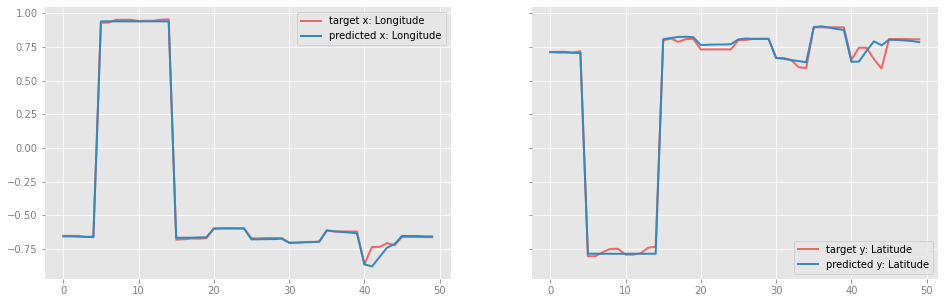

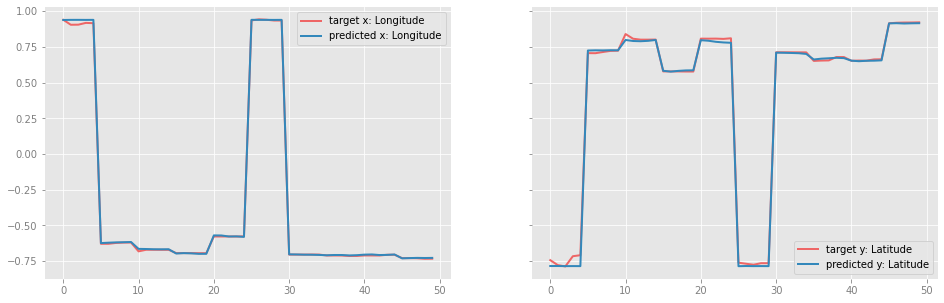

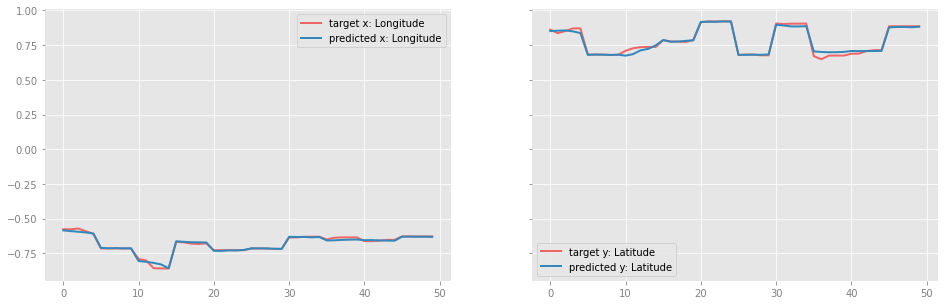

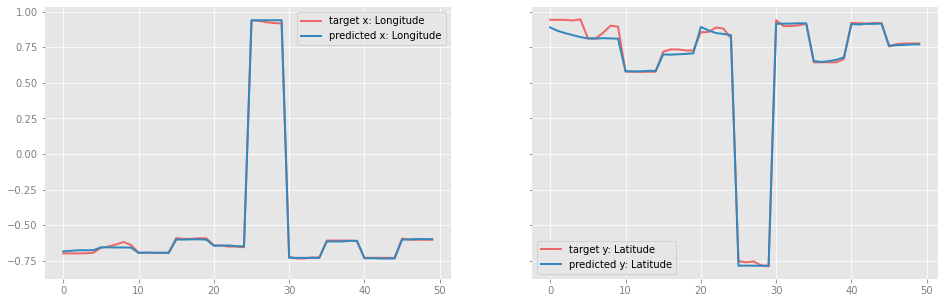

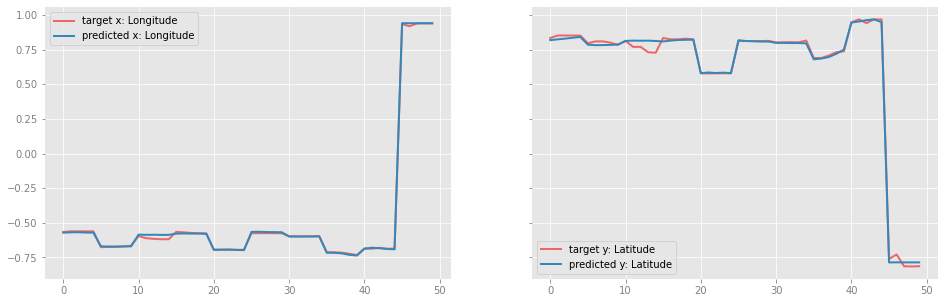

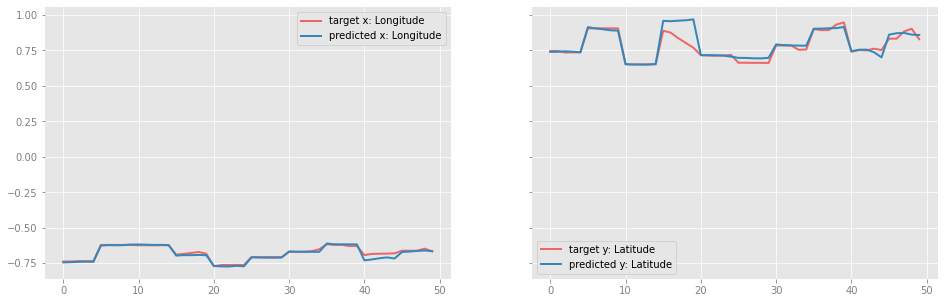

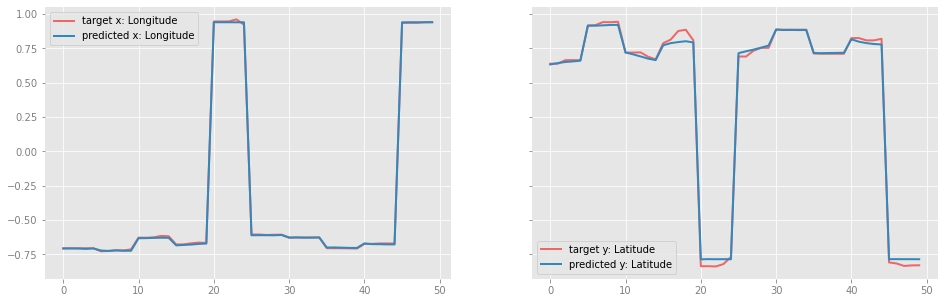

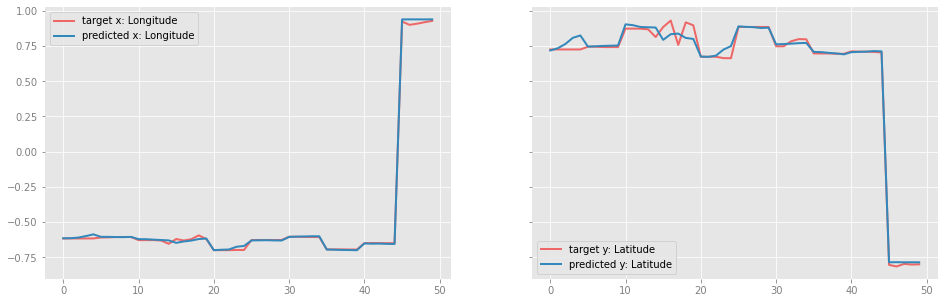

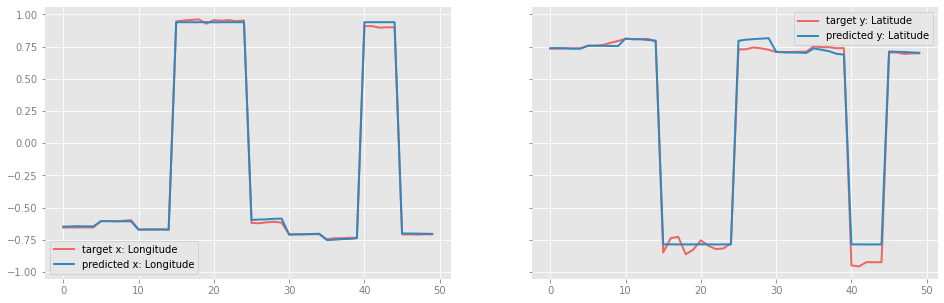

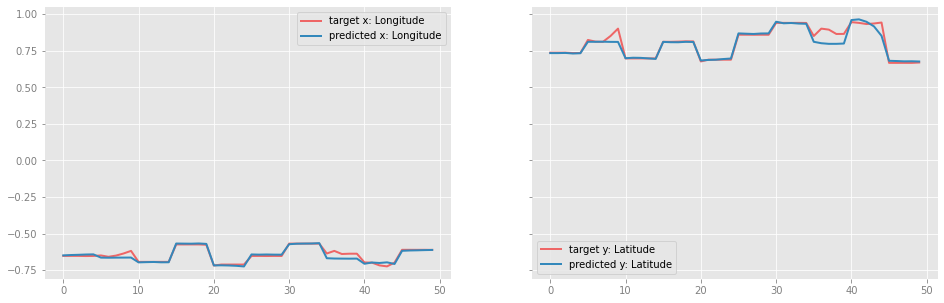

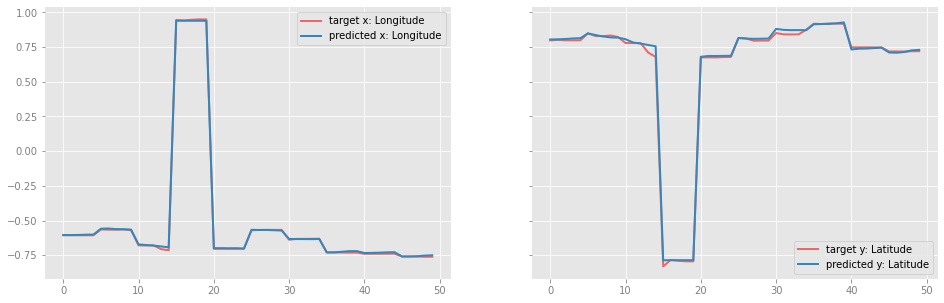

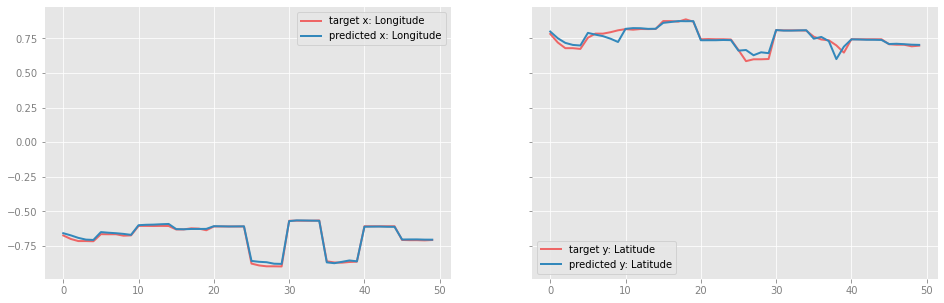

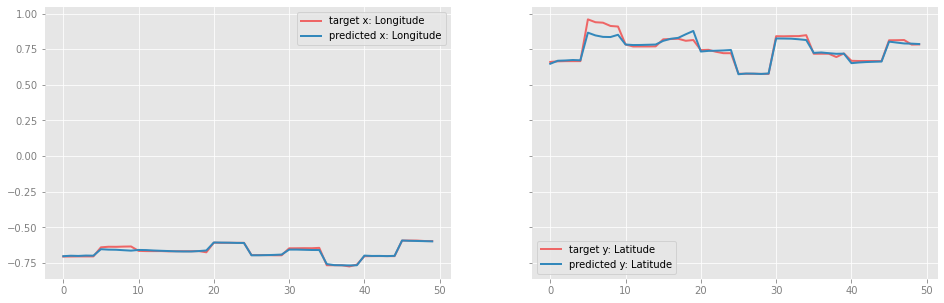

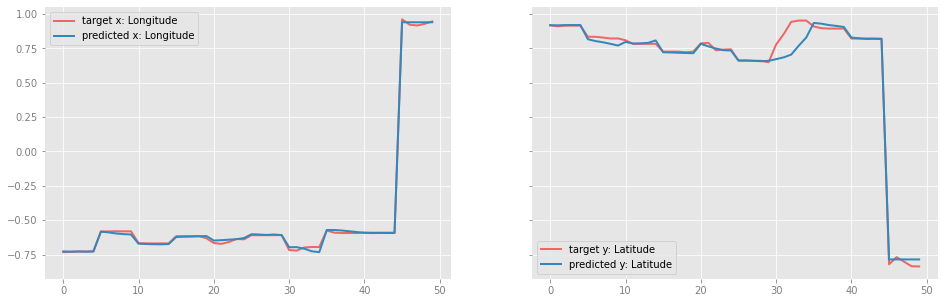

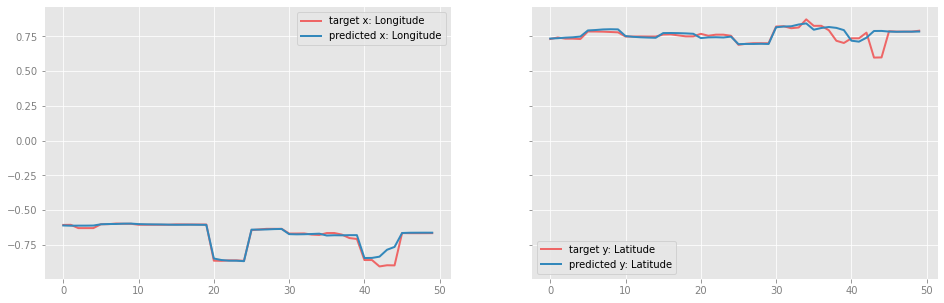

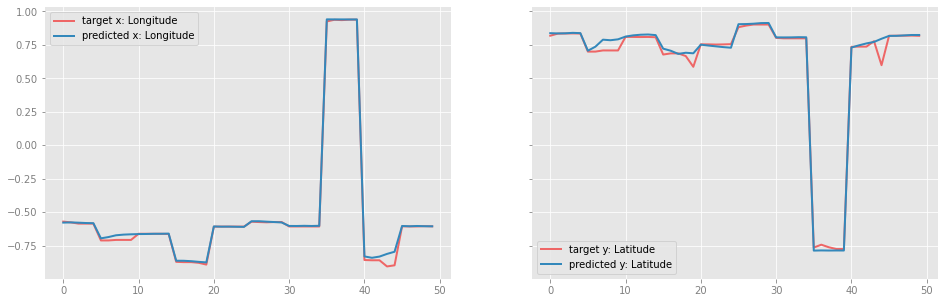

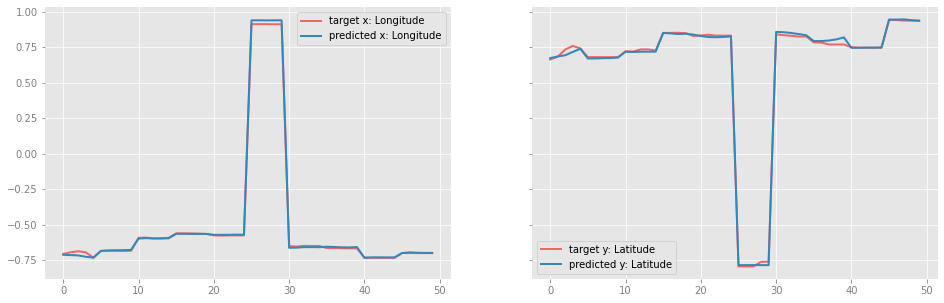

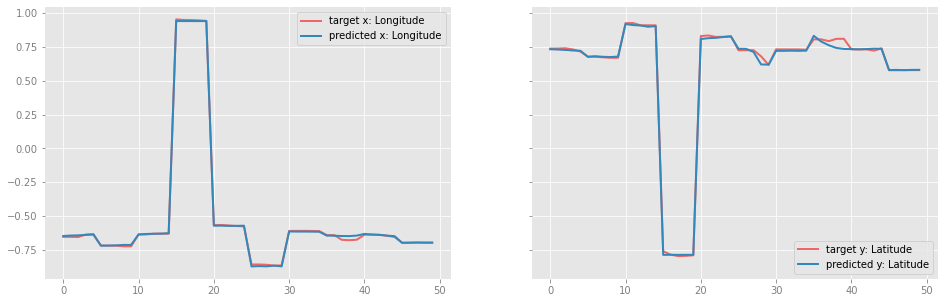

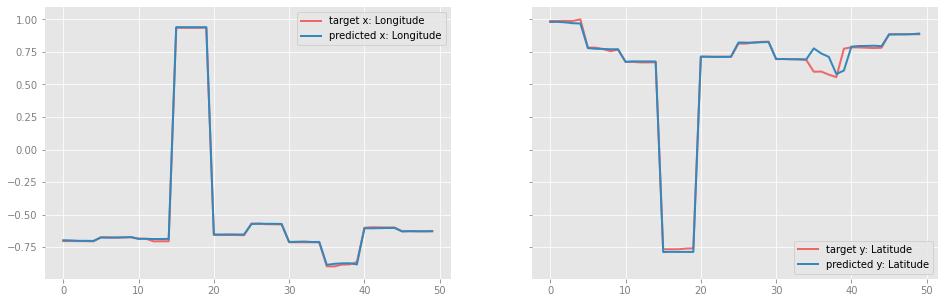

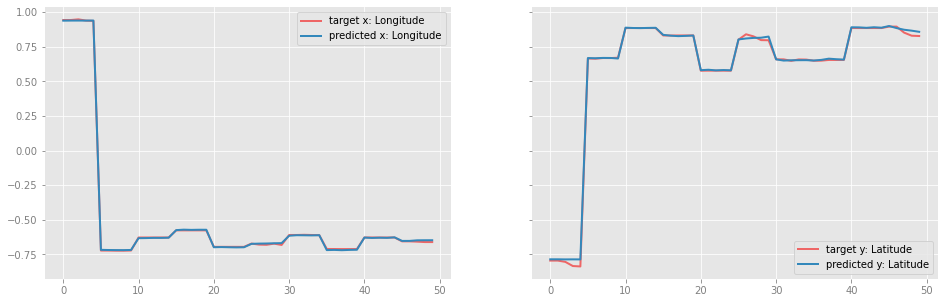

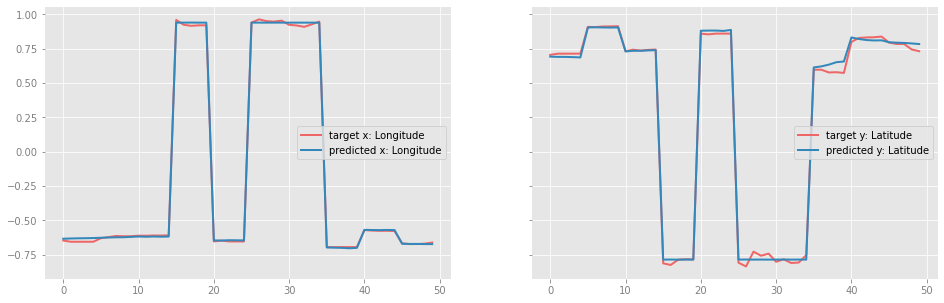

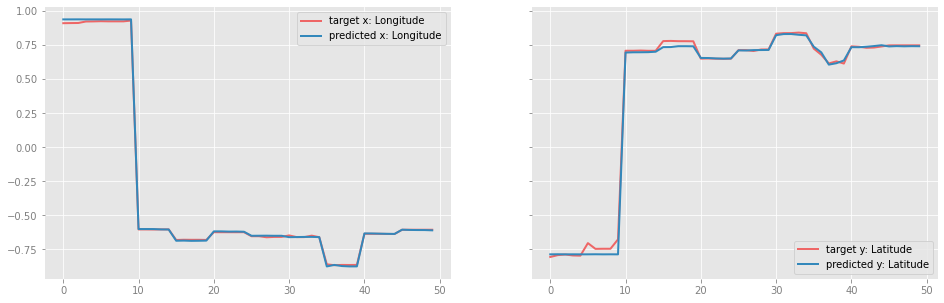

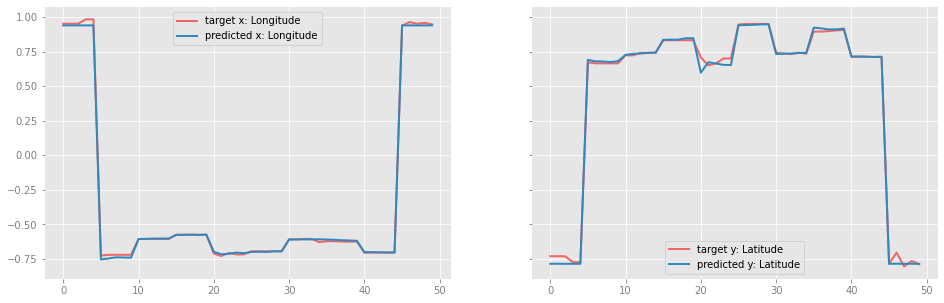

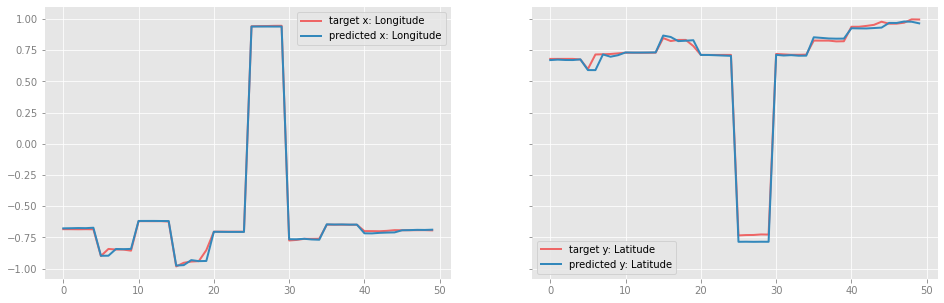

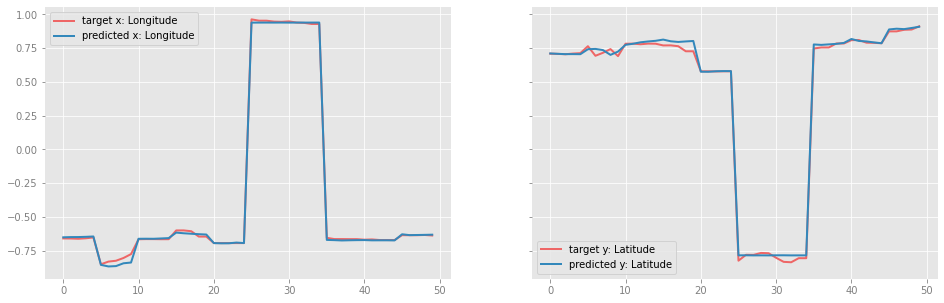

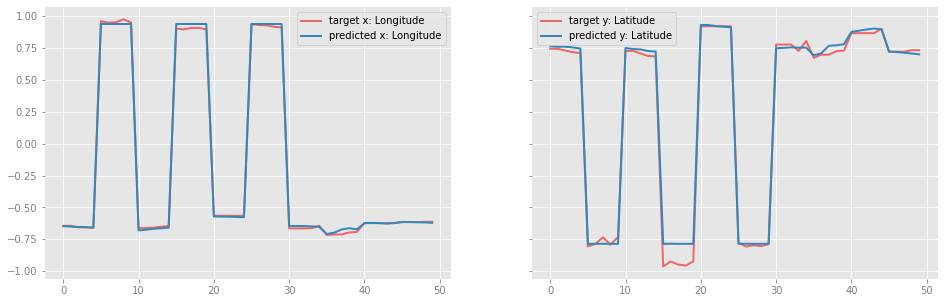

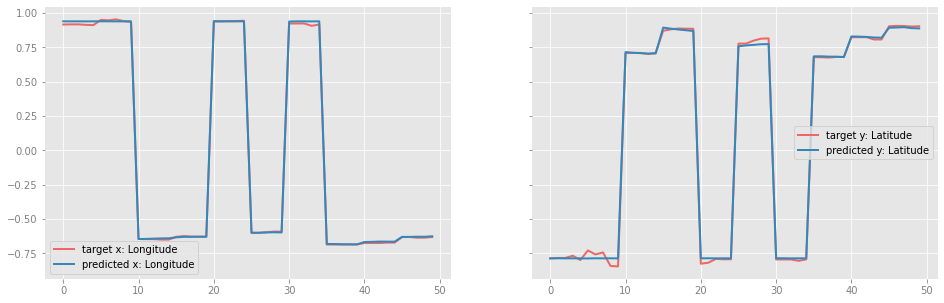

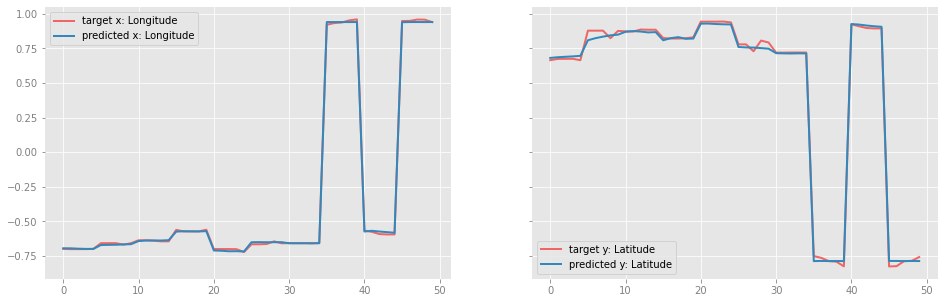

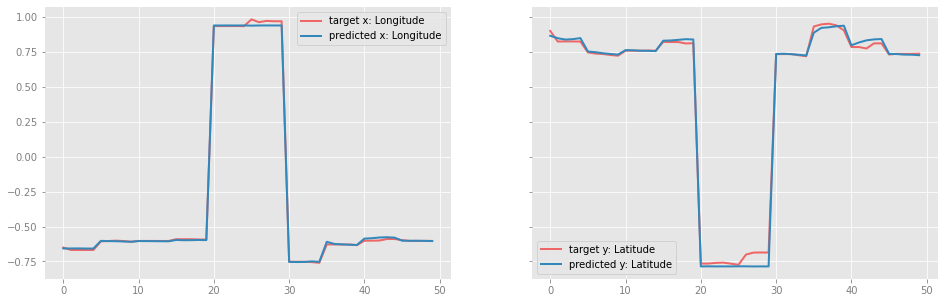

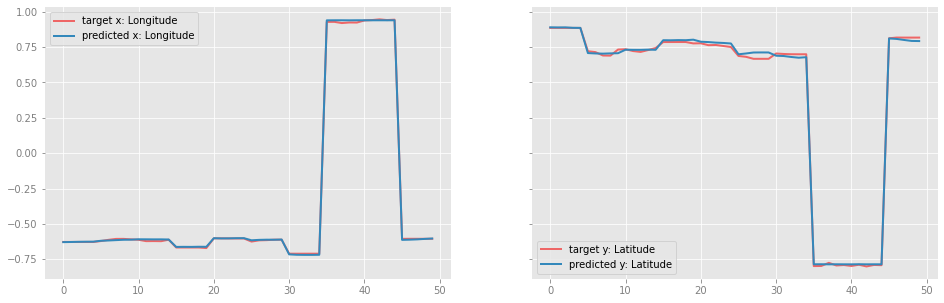

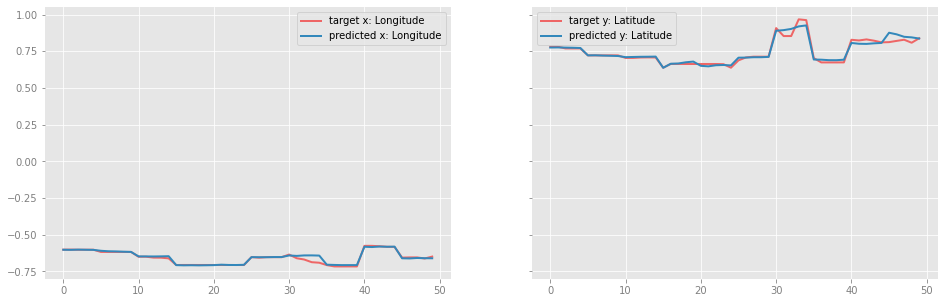

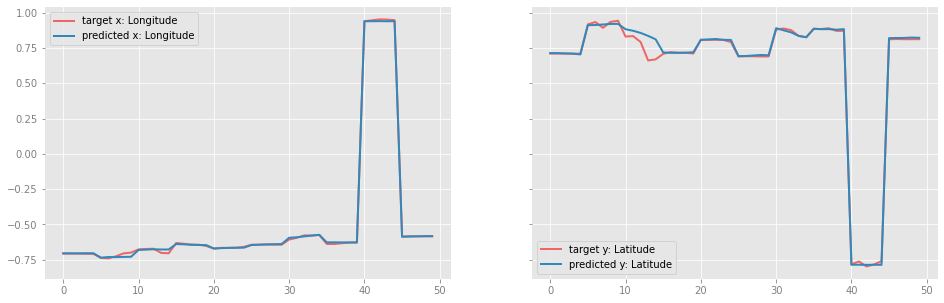

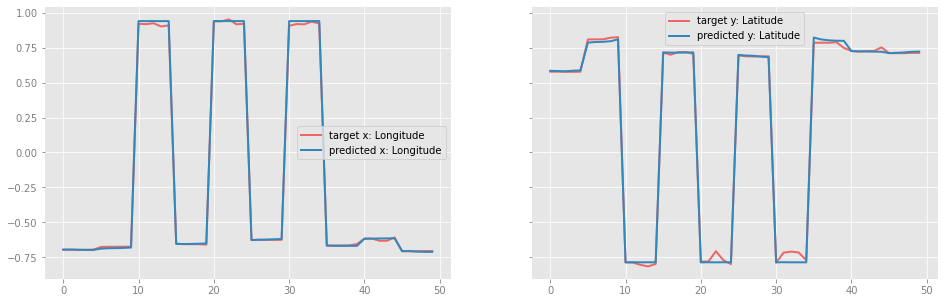

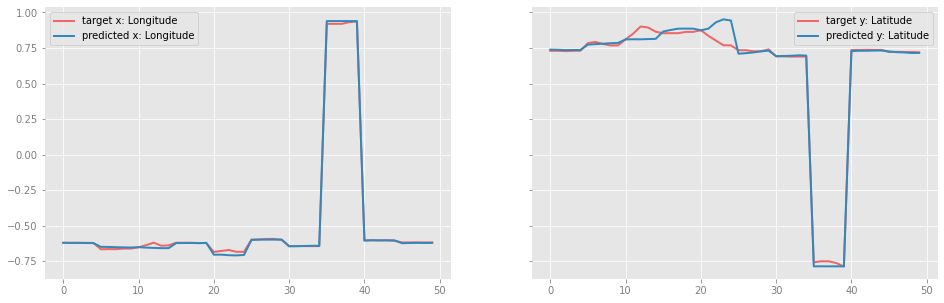

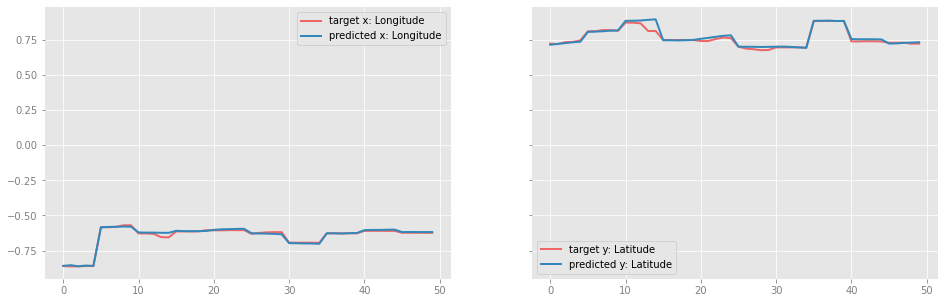

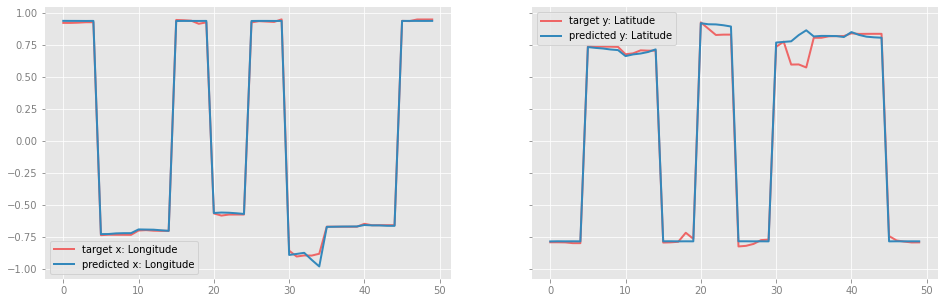

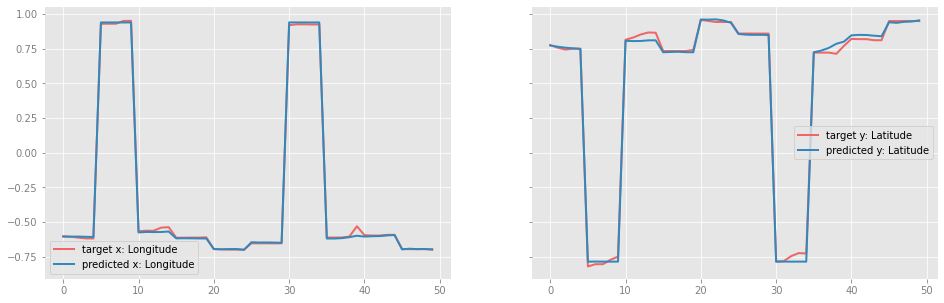

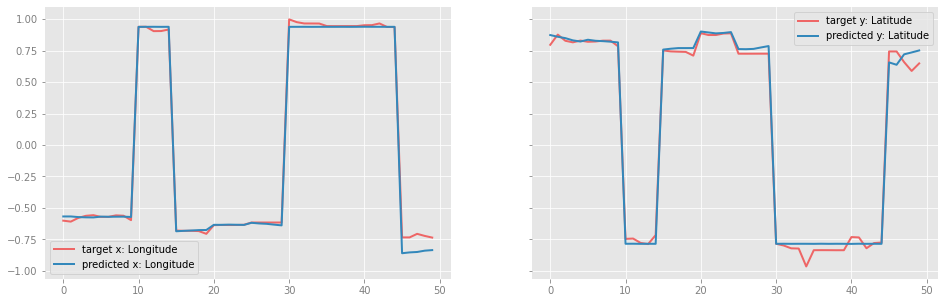

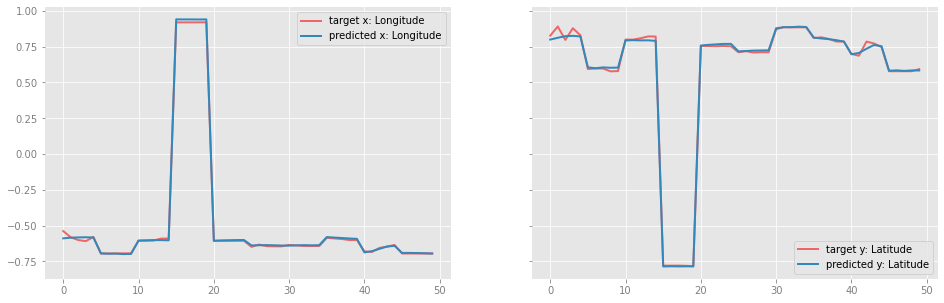

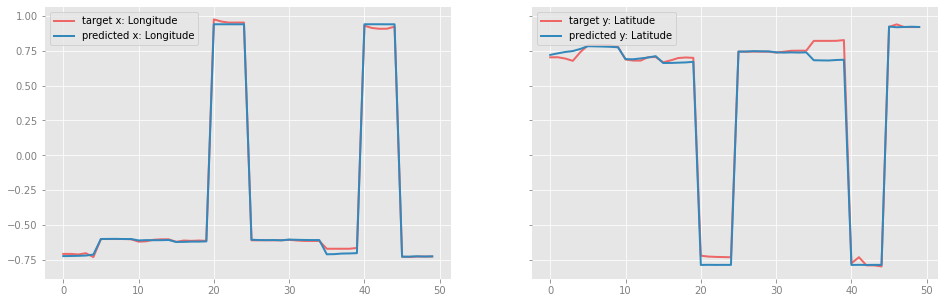

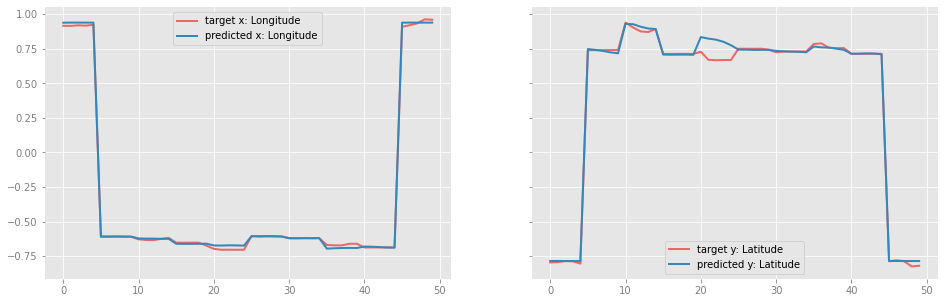

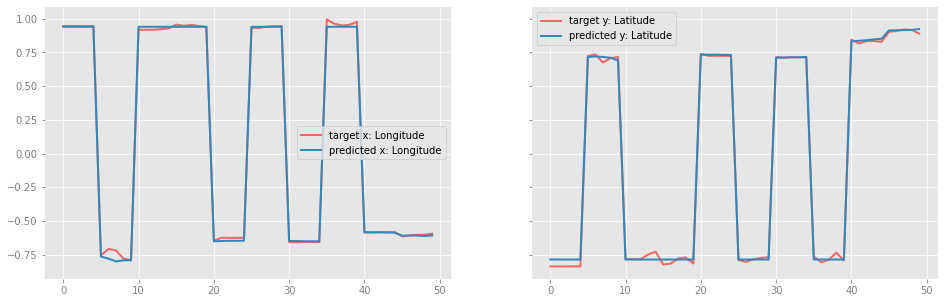

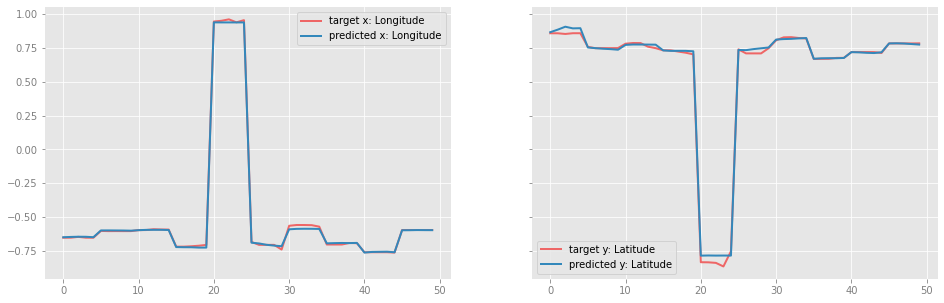

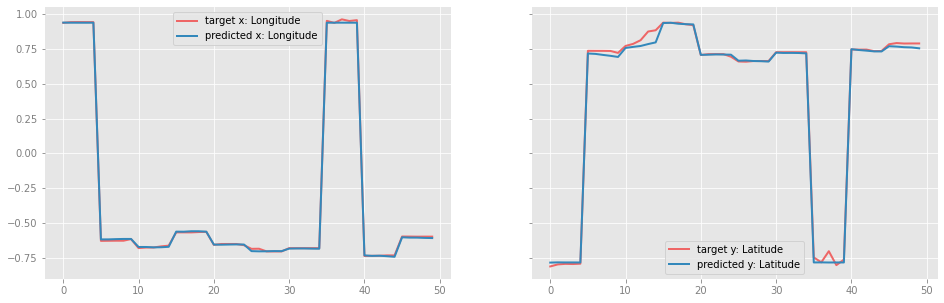

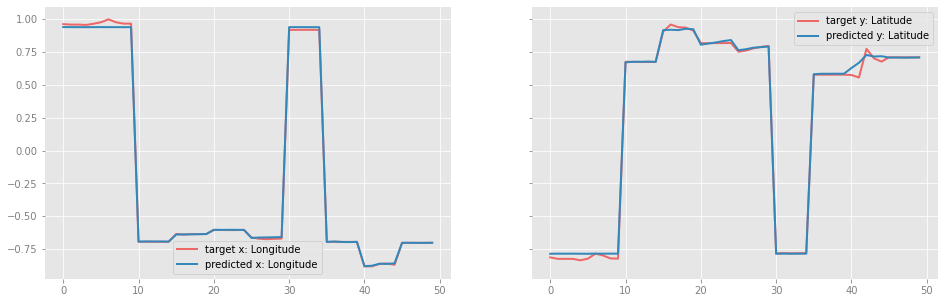

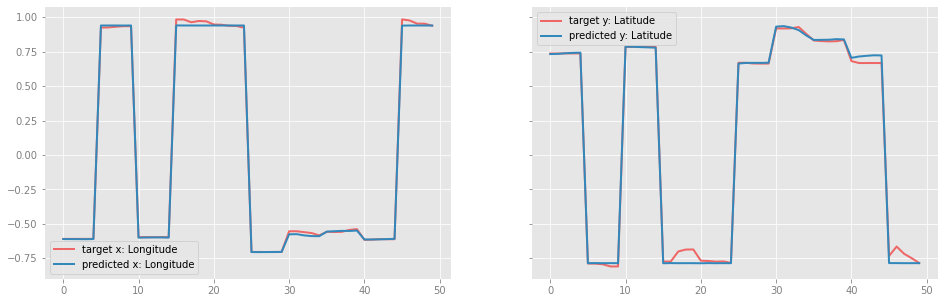

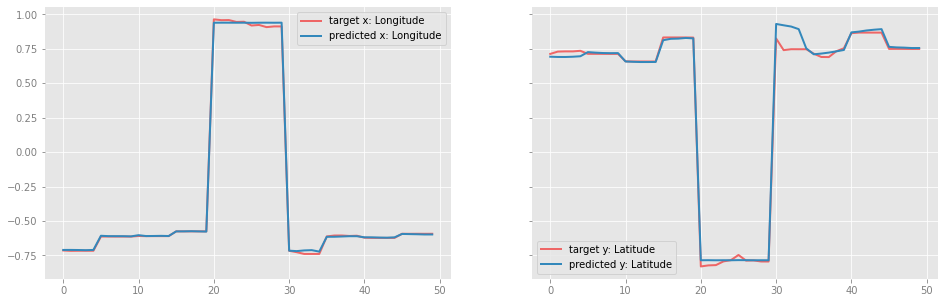

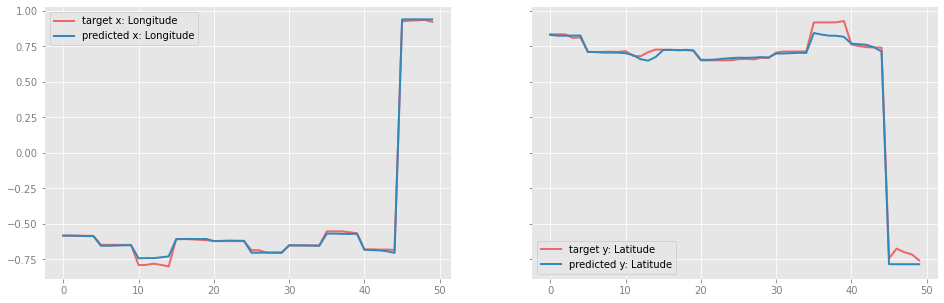

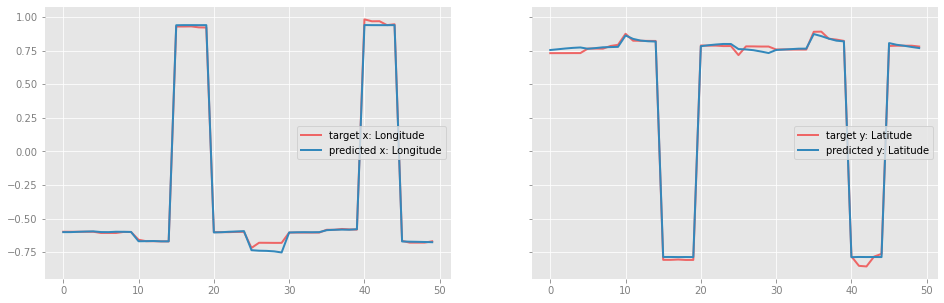

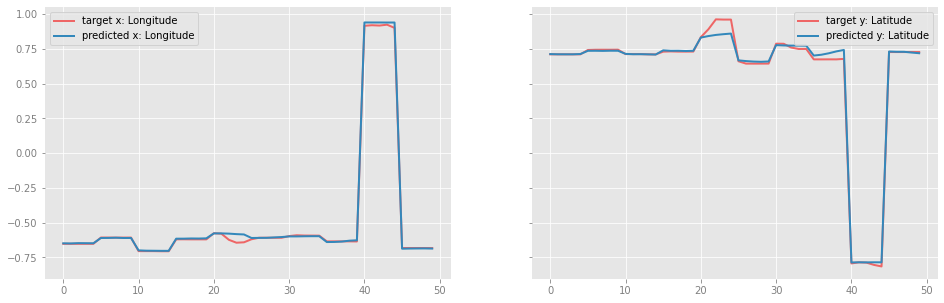

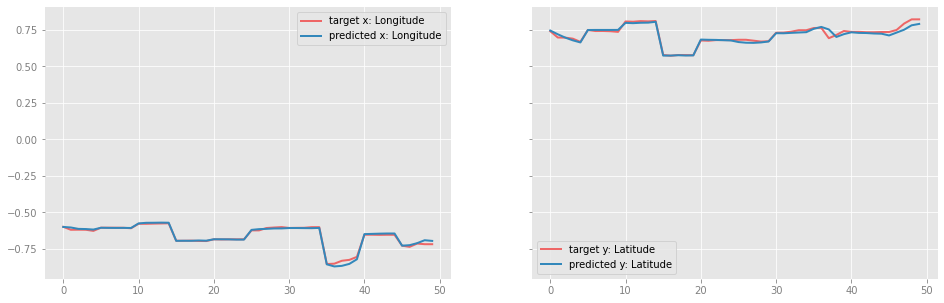

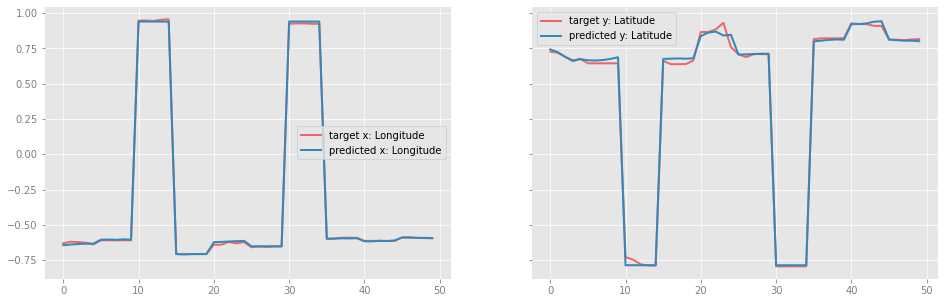

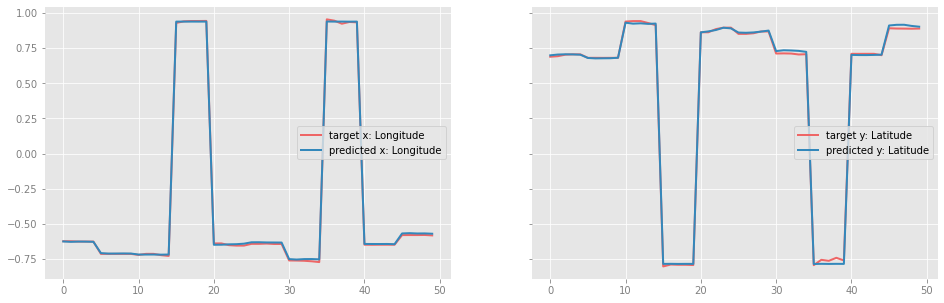

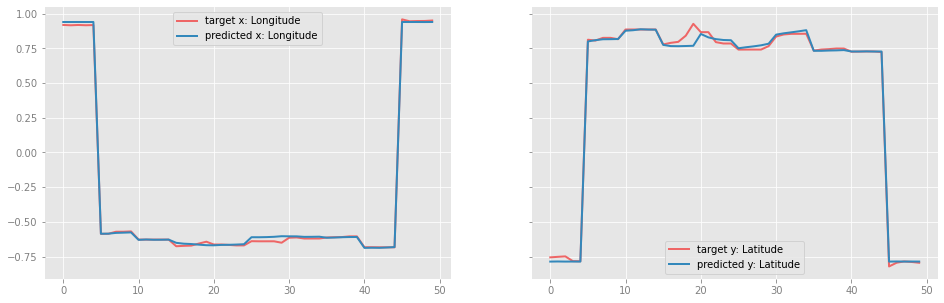

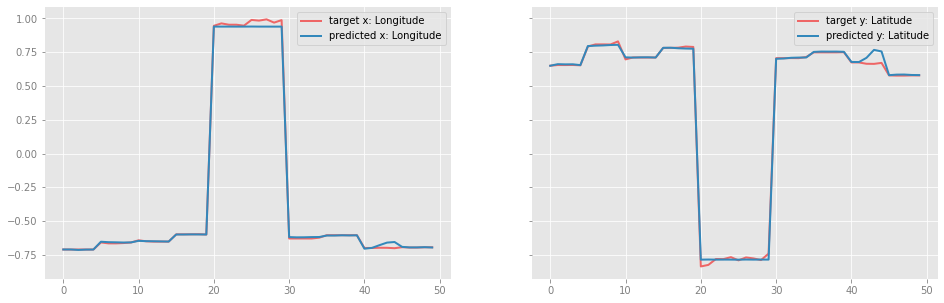

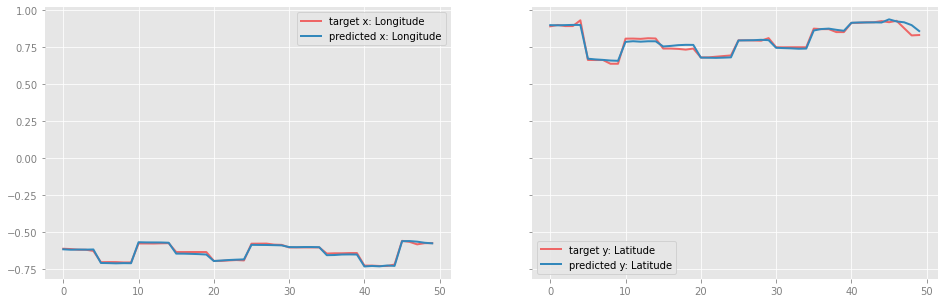

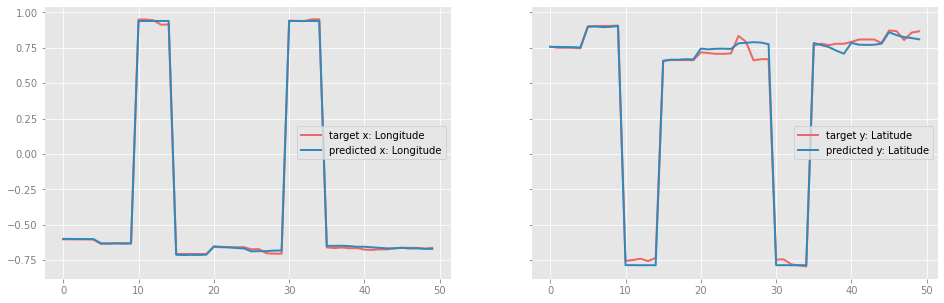

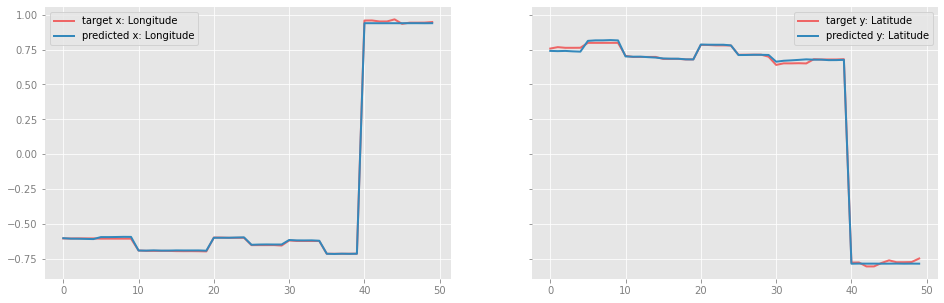

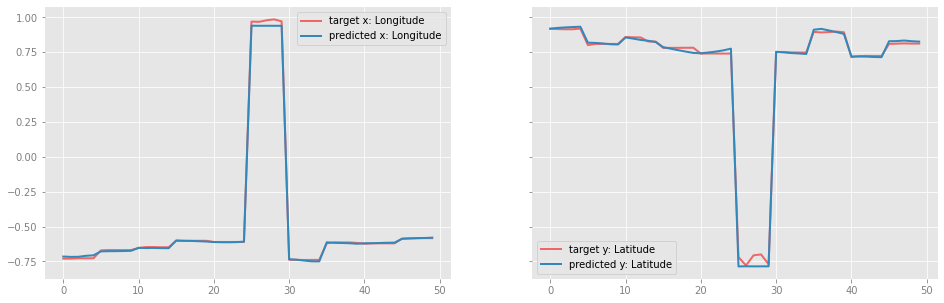

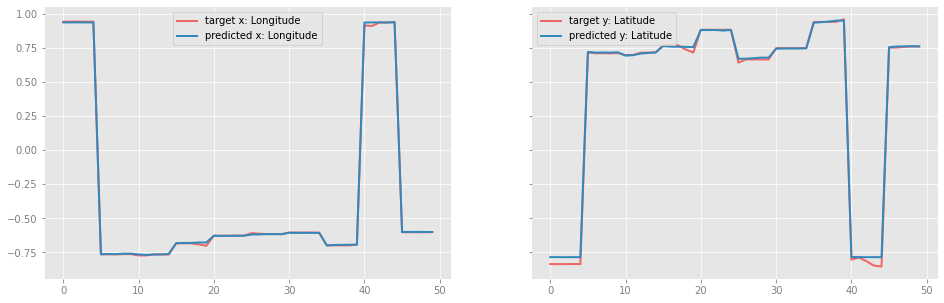

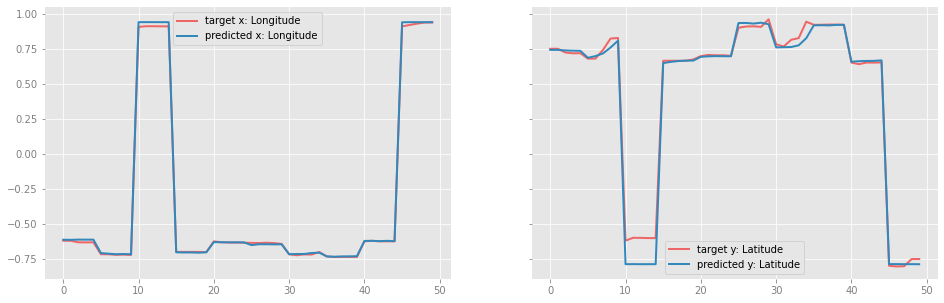

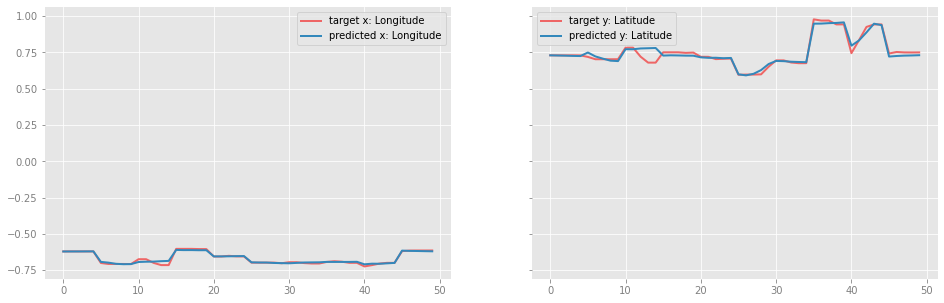

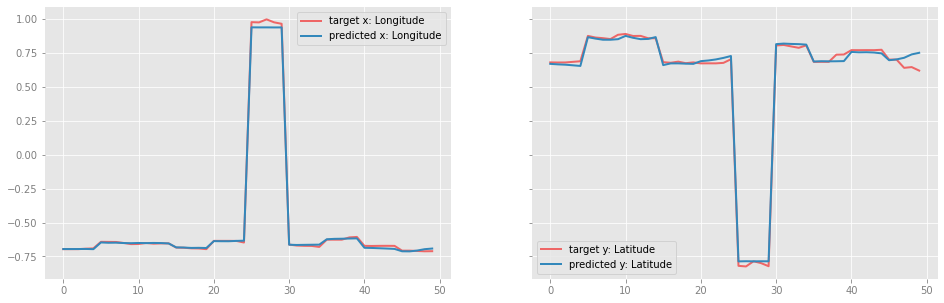

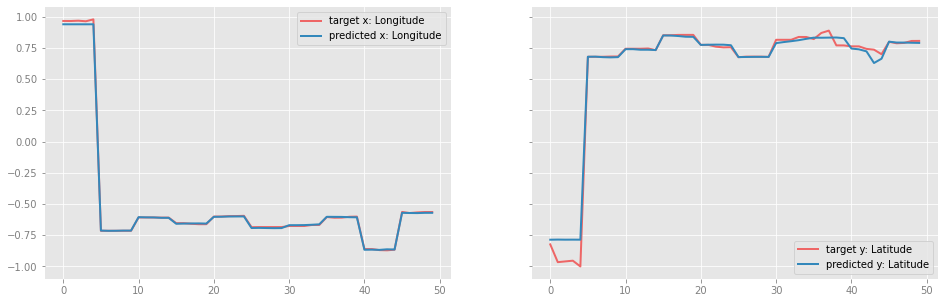

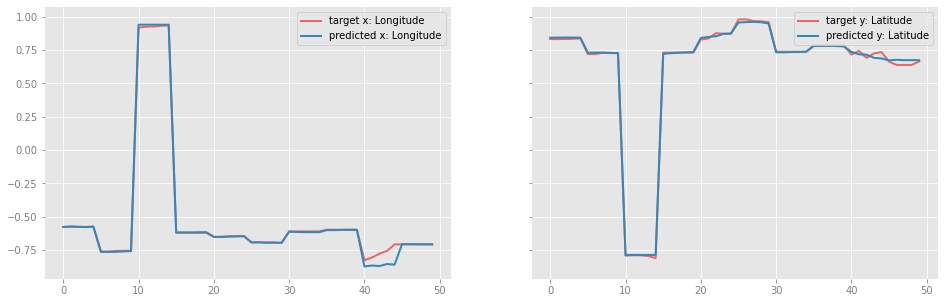

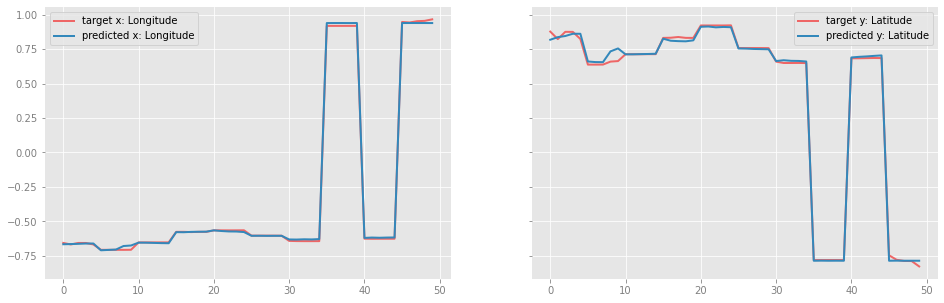

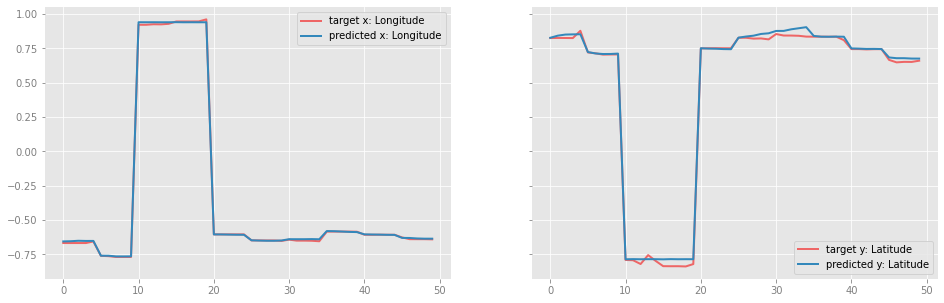

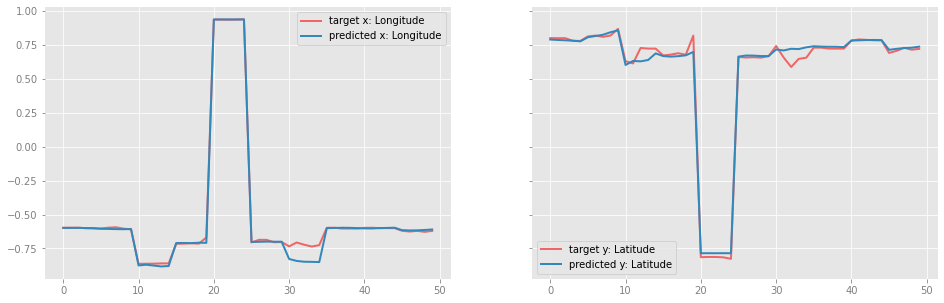

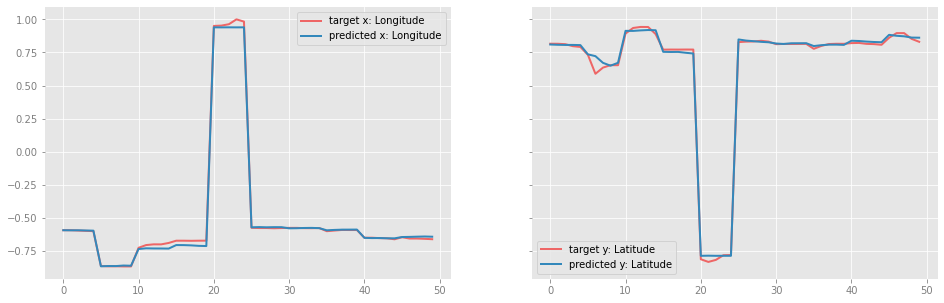

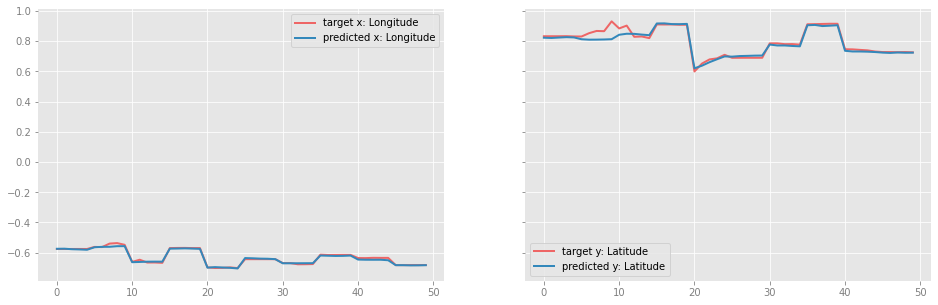

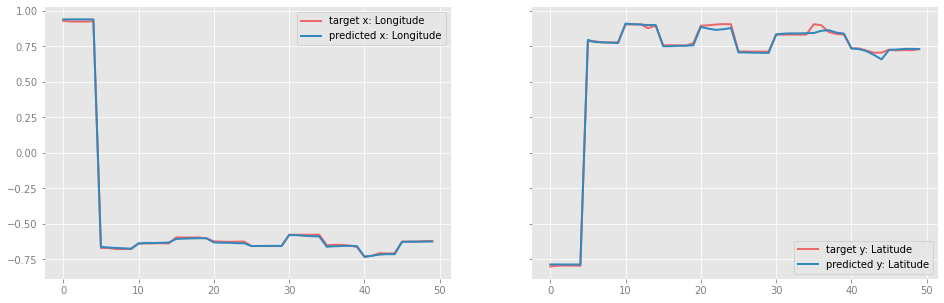

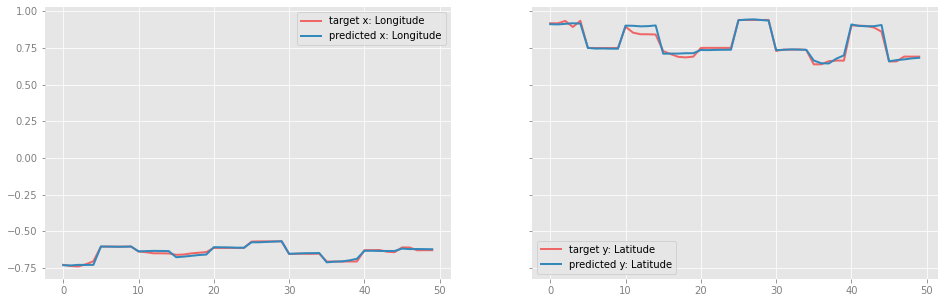

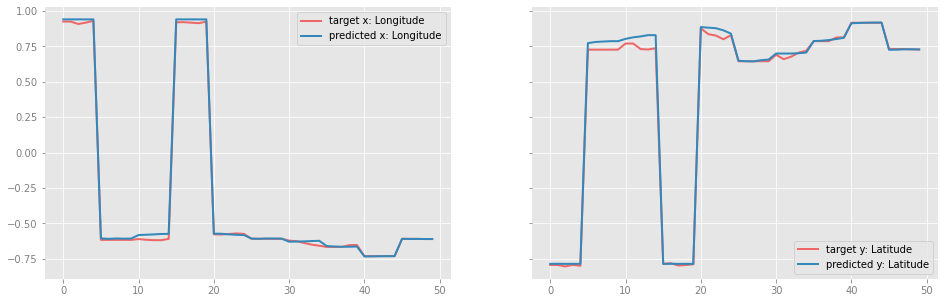

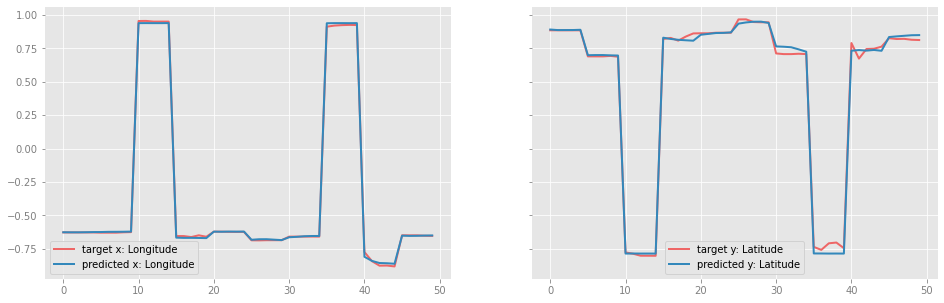

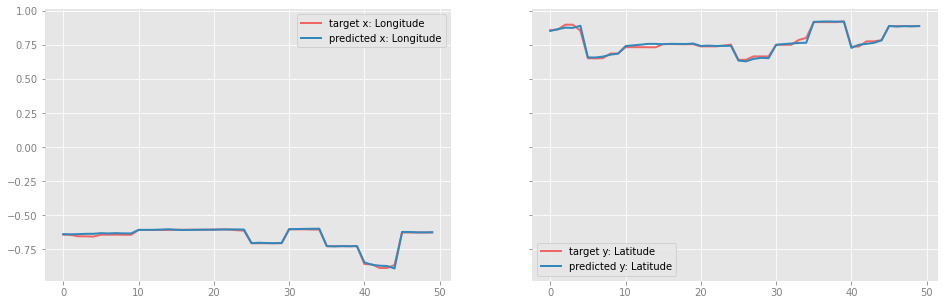

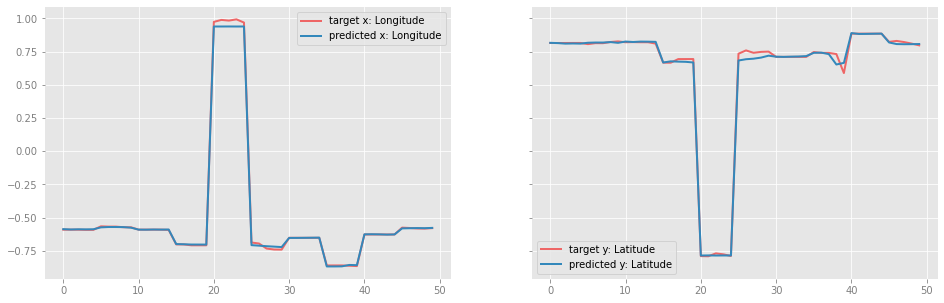

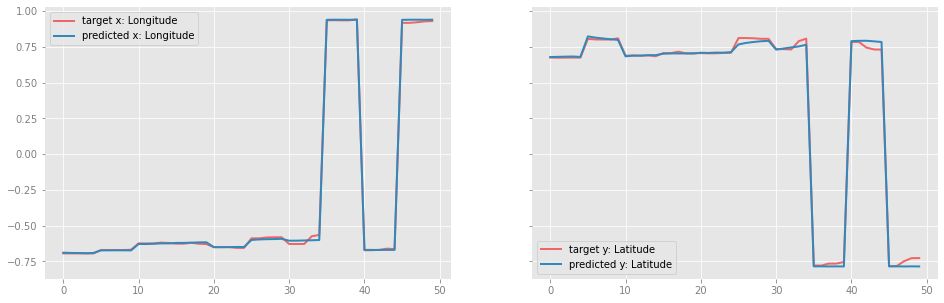

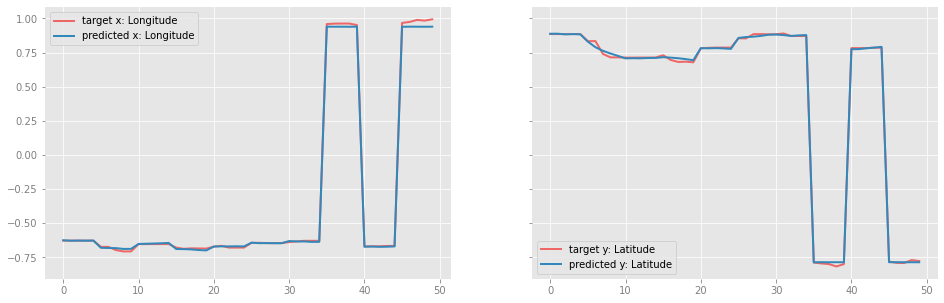

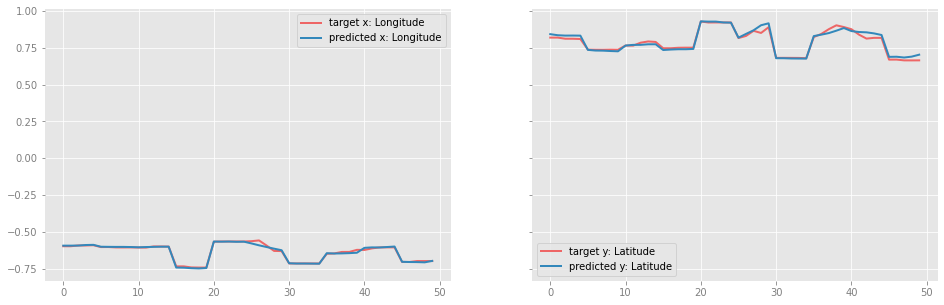

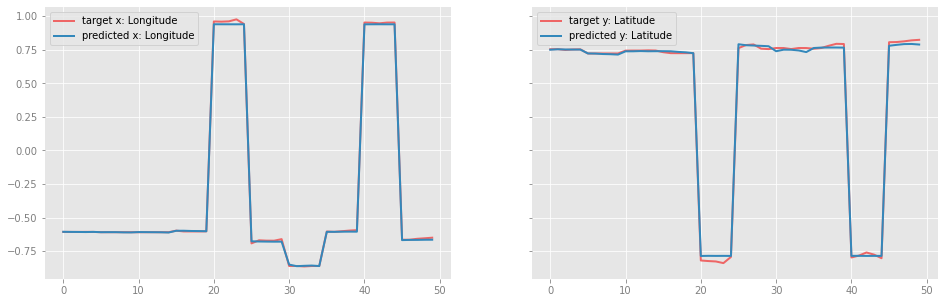

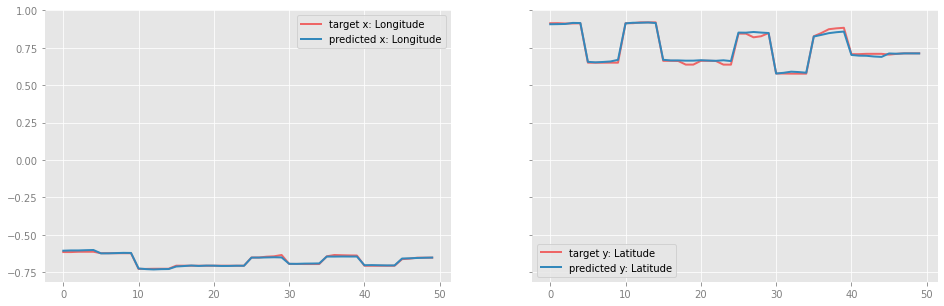

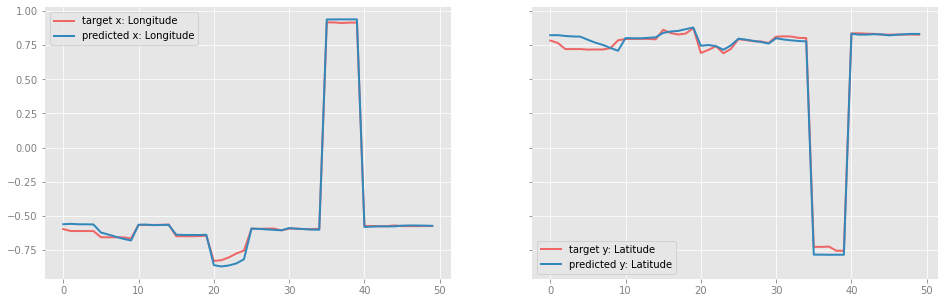

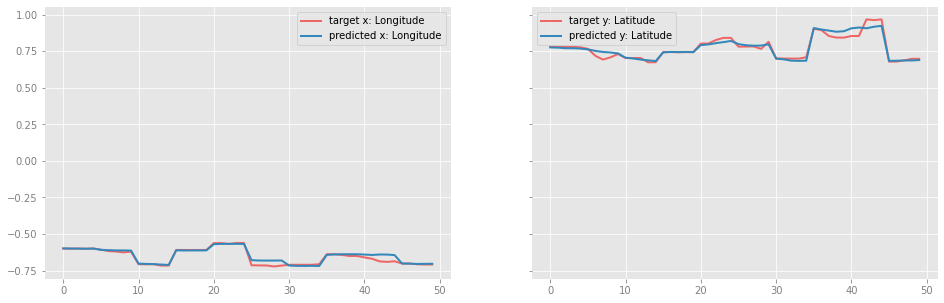

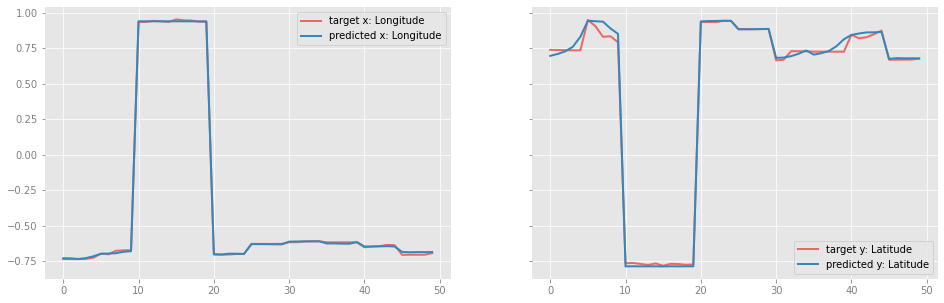

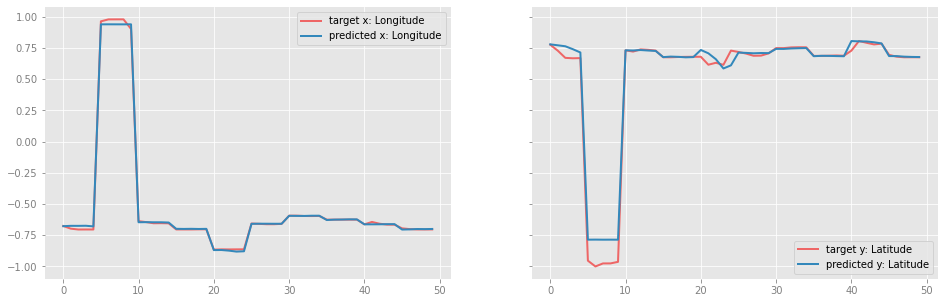

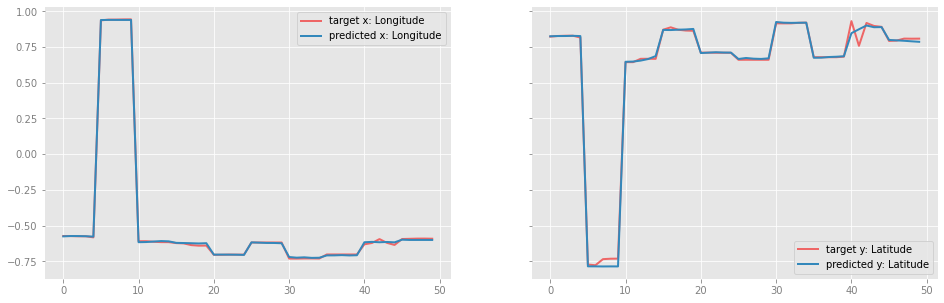

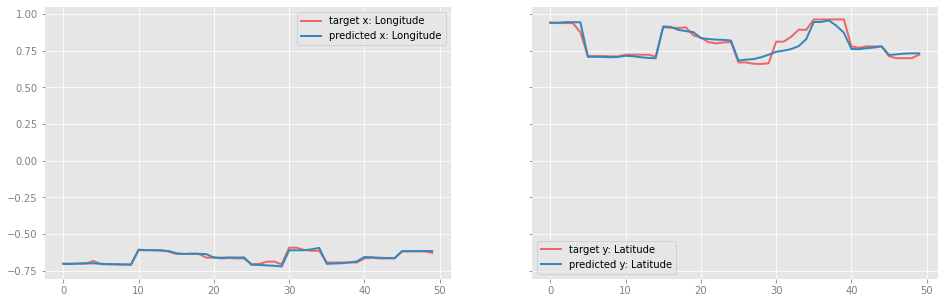

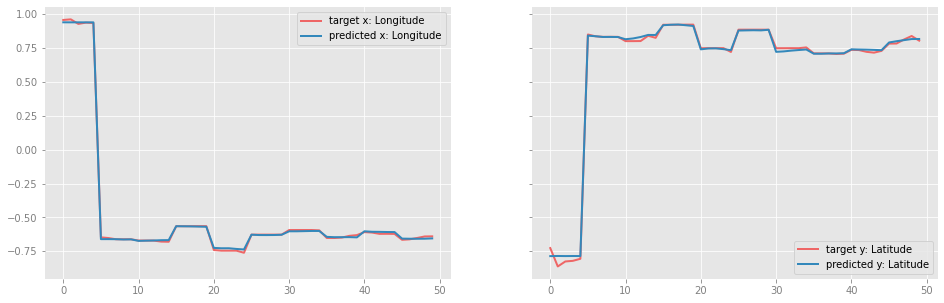

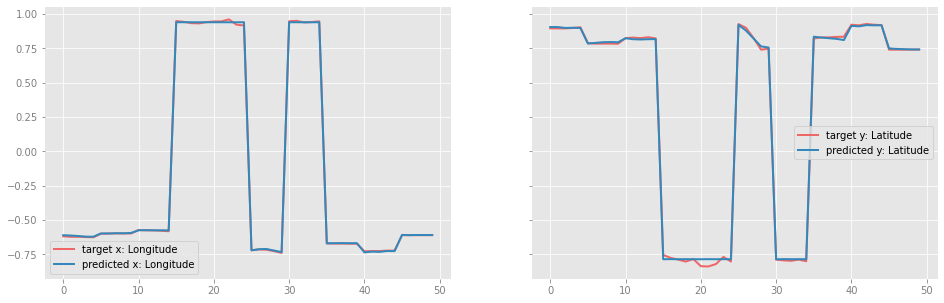

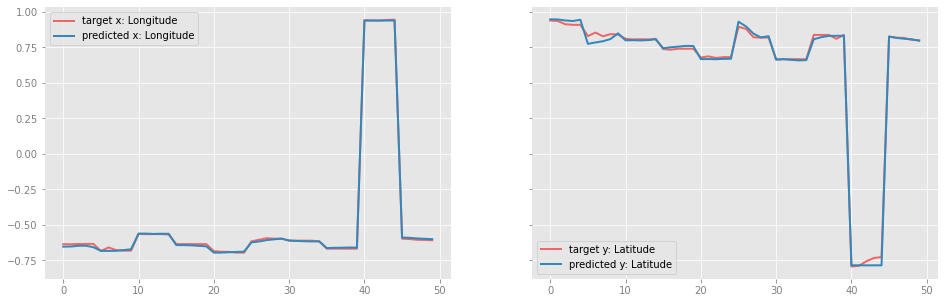

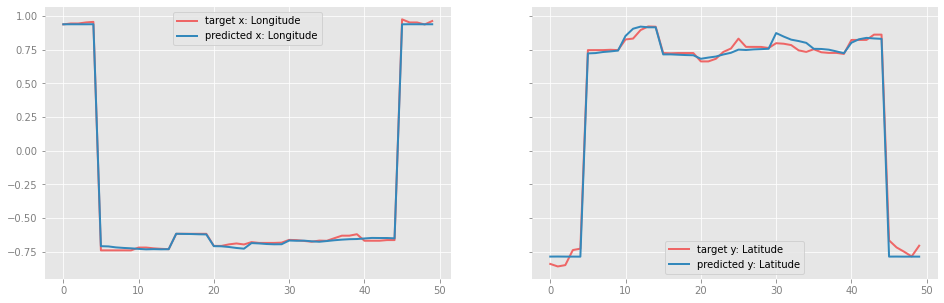

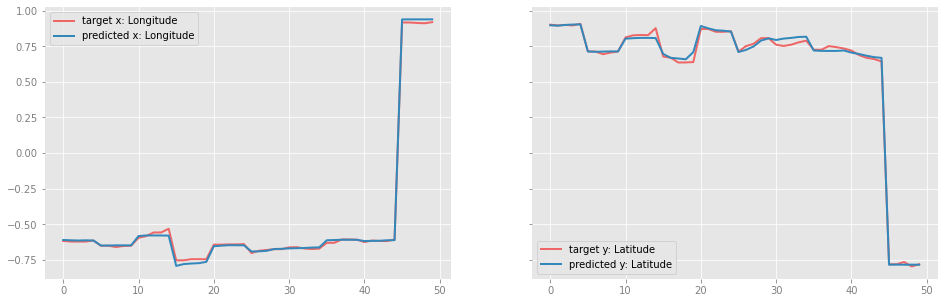

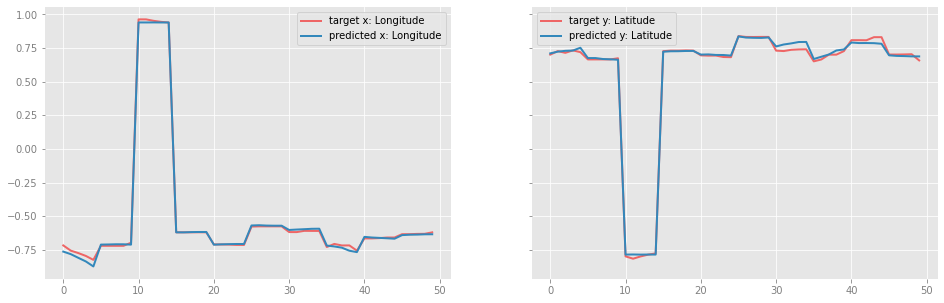

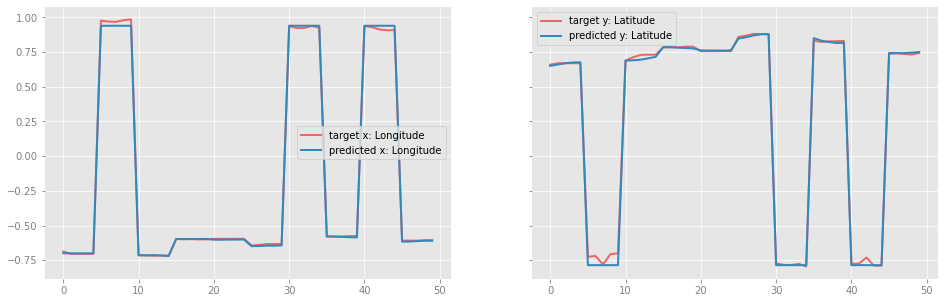

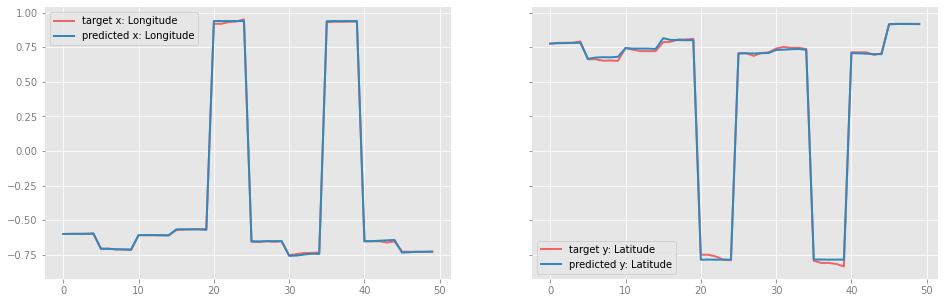

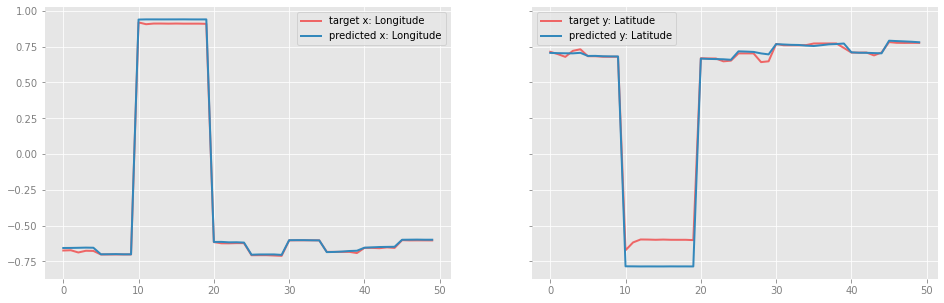

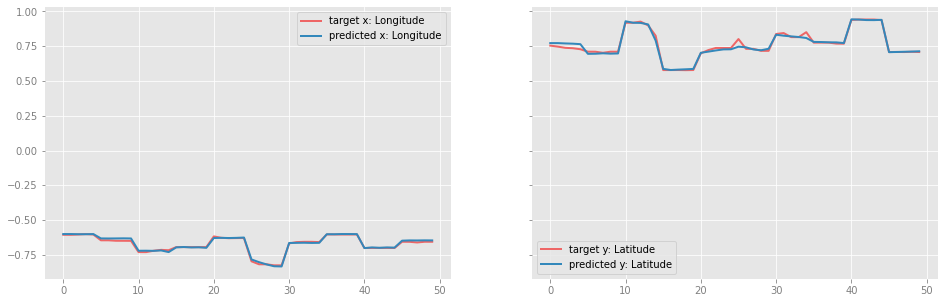

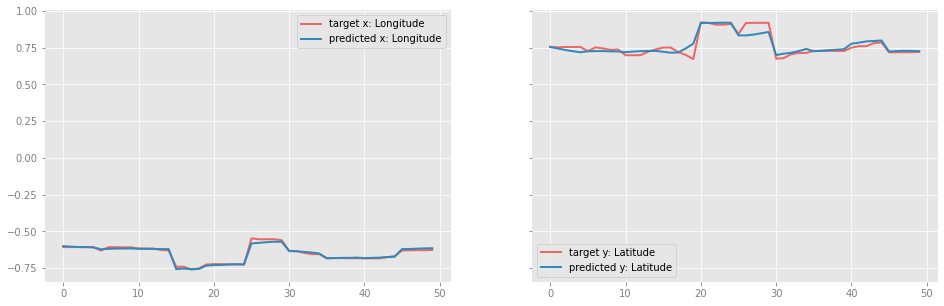

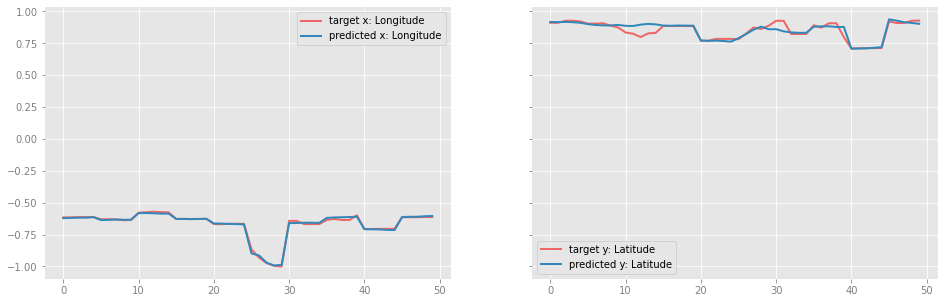

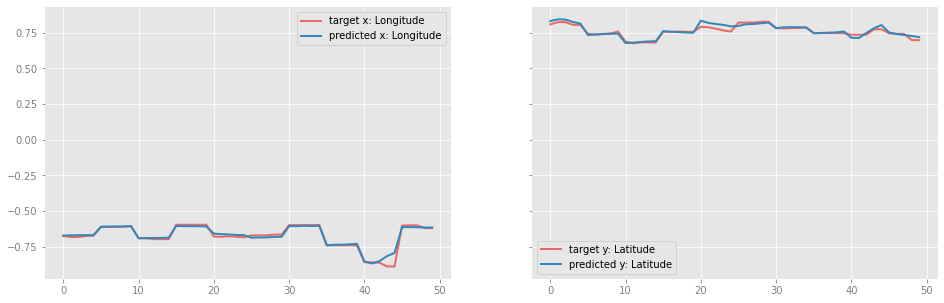

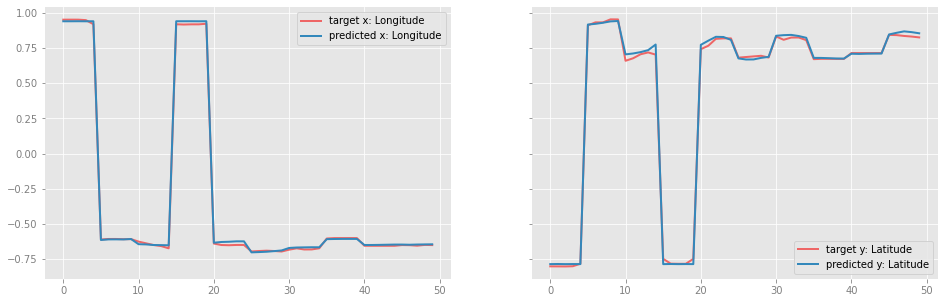

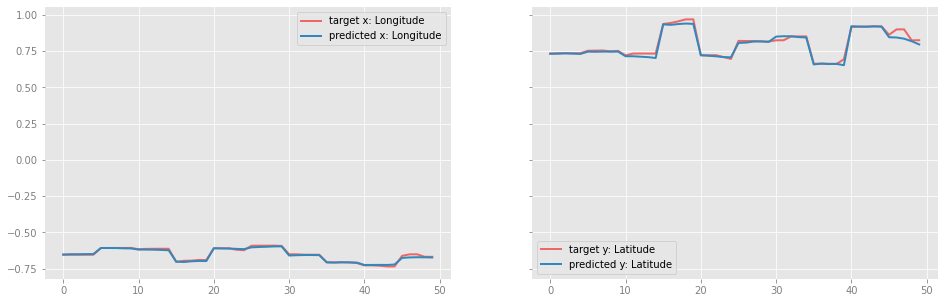

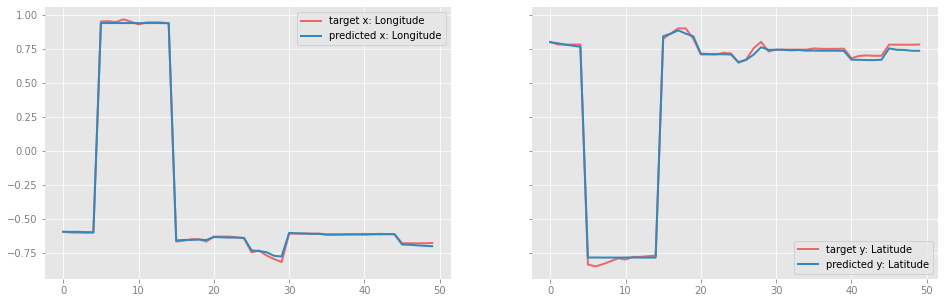

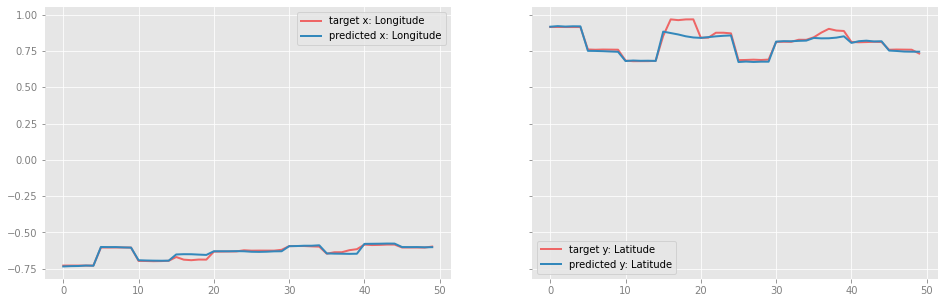

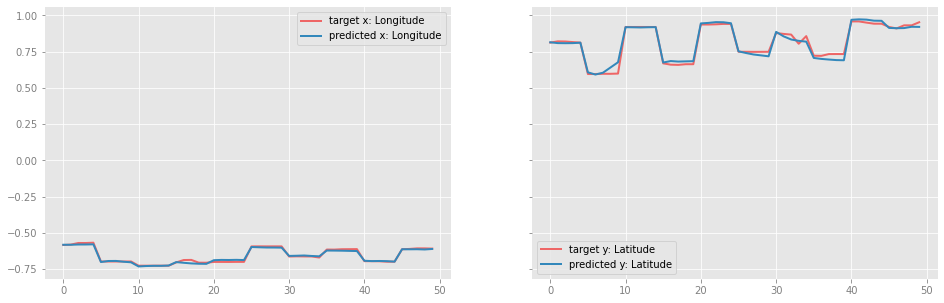

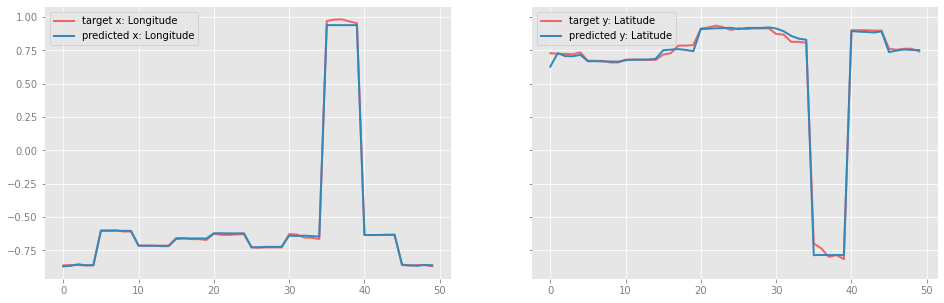

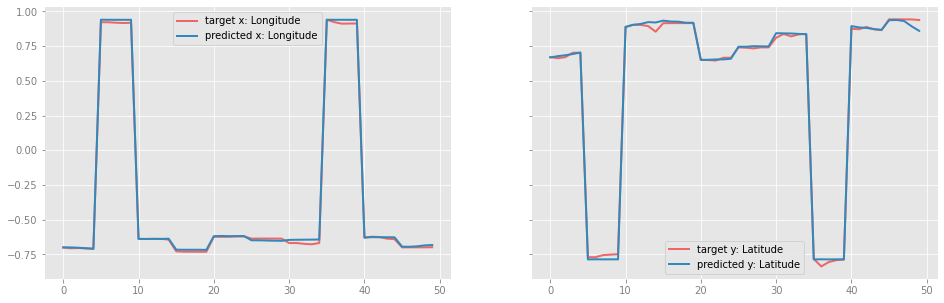

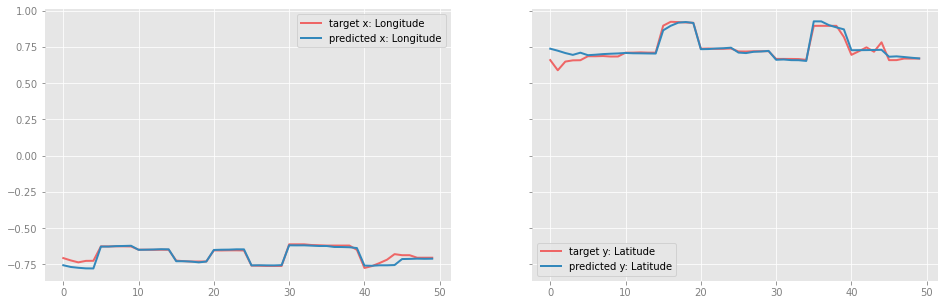

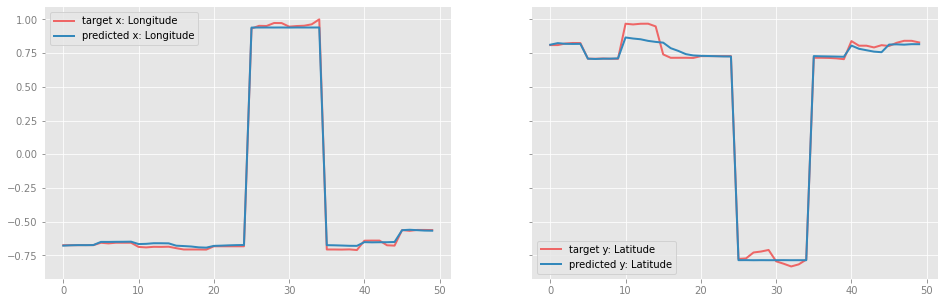

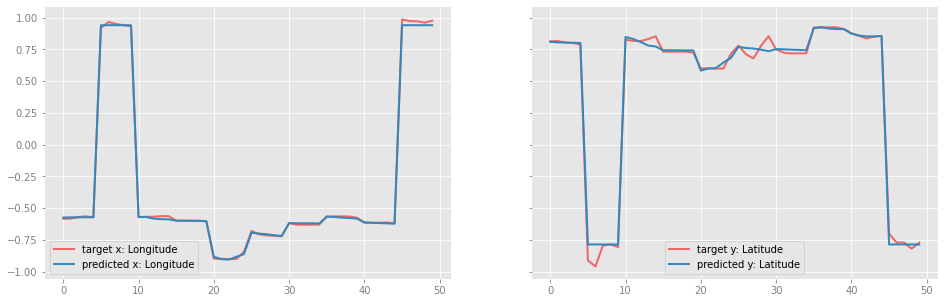

In [ ]:
model.to(device)
for data,target, category in test_loader:
    out, latent = model(data.float().to(device), training = False, is_classification=False)
    target = target.cpu().detach().numpy()
    target = target.reshape(target.shape[0]*target.shape[1],target.shape[2])
    out = out.cpu().detach().numpy()
    out = out.reshape(out.shape[0]*out.shape[1],out.shape[2])
    
    # plt.plot(target[:,0],target[:,1],label='Target before scaling')
    # plt.legend()
    # plt.show()
    # plt.plot(out[:,0],out[:,1],label='output before scaling')
    # plt.legend()
    # plt.show()

    # for index, i in enumerate(list(range(target.shape[1]))):
    #     scaler = scalers['scaler_'+str(i)]
    #     target[:,index] = scaler.inverse_transform(target[:,index].reshape(1, -1))
    #     out[:,index] = scaler.inverse_transform(out[:,index].reshape(1, -1))
     

    plt.ticklabel_format(useOffset=False)
    ax[0].plot(target[:,0],label="target x: Longitude")
    ax[0].plot(out[:,0], label='predicted x: Longitude')
    ax[0].legend()
    ax[1].plot(target[:,1],label="target y: Latitude")
    ax[1].plot(out[:,1], label='predicted y: Latitude')
    ax[1].legend()
    plt.savefig('predictions')
    plt.show()   



In [ ]:
# Plot all 2D combination of latent space
import plotly.express as px

def DisplayLatentDynamics(latent):
    r"""Visualize the dynamics of combination of latents 
    Args:
    latent(tensor): Each point in the list is latent's state at the end of a sequence of each batch.
    Latent shape (batch_size, latent_dim)"""
    
    latents = {}
    latents.fromkeys(list(range(latent.shape[1]))) 
    for i in range(latent.shape[1]):
        latents[f'{i}']=latent[:,i].cpu().detach().numpy()
    fig= px.scatter_matrix(latents)
    fig.update_layout(
    autosize=False,
    width=1600,
    height=1000,)
    plt.savefig("latent units")
    return fig.show()


In [ ]:
DisplayLatentDynamics(latent)

<Figure size 432x288 with 0 Axes>

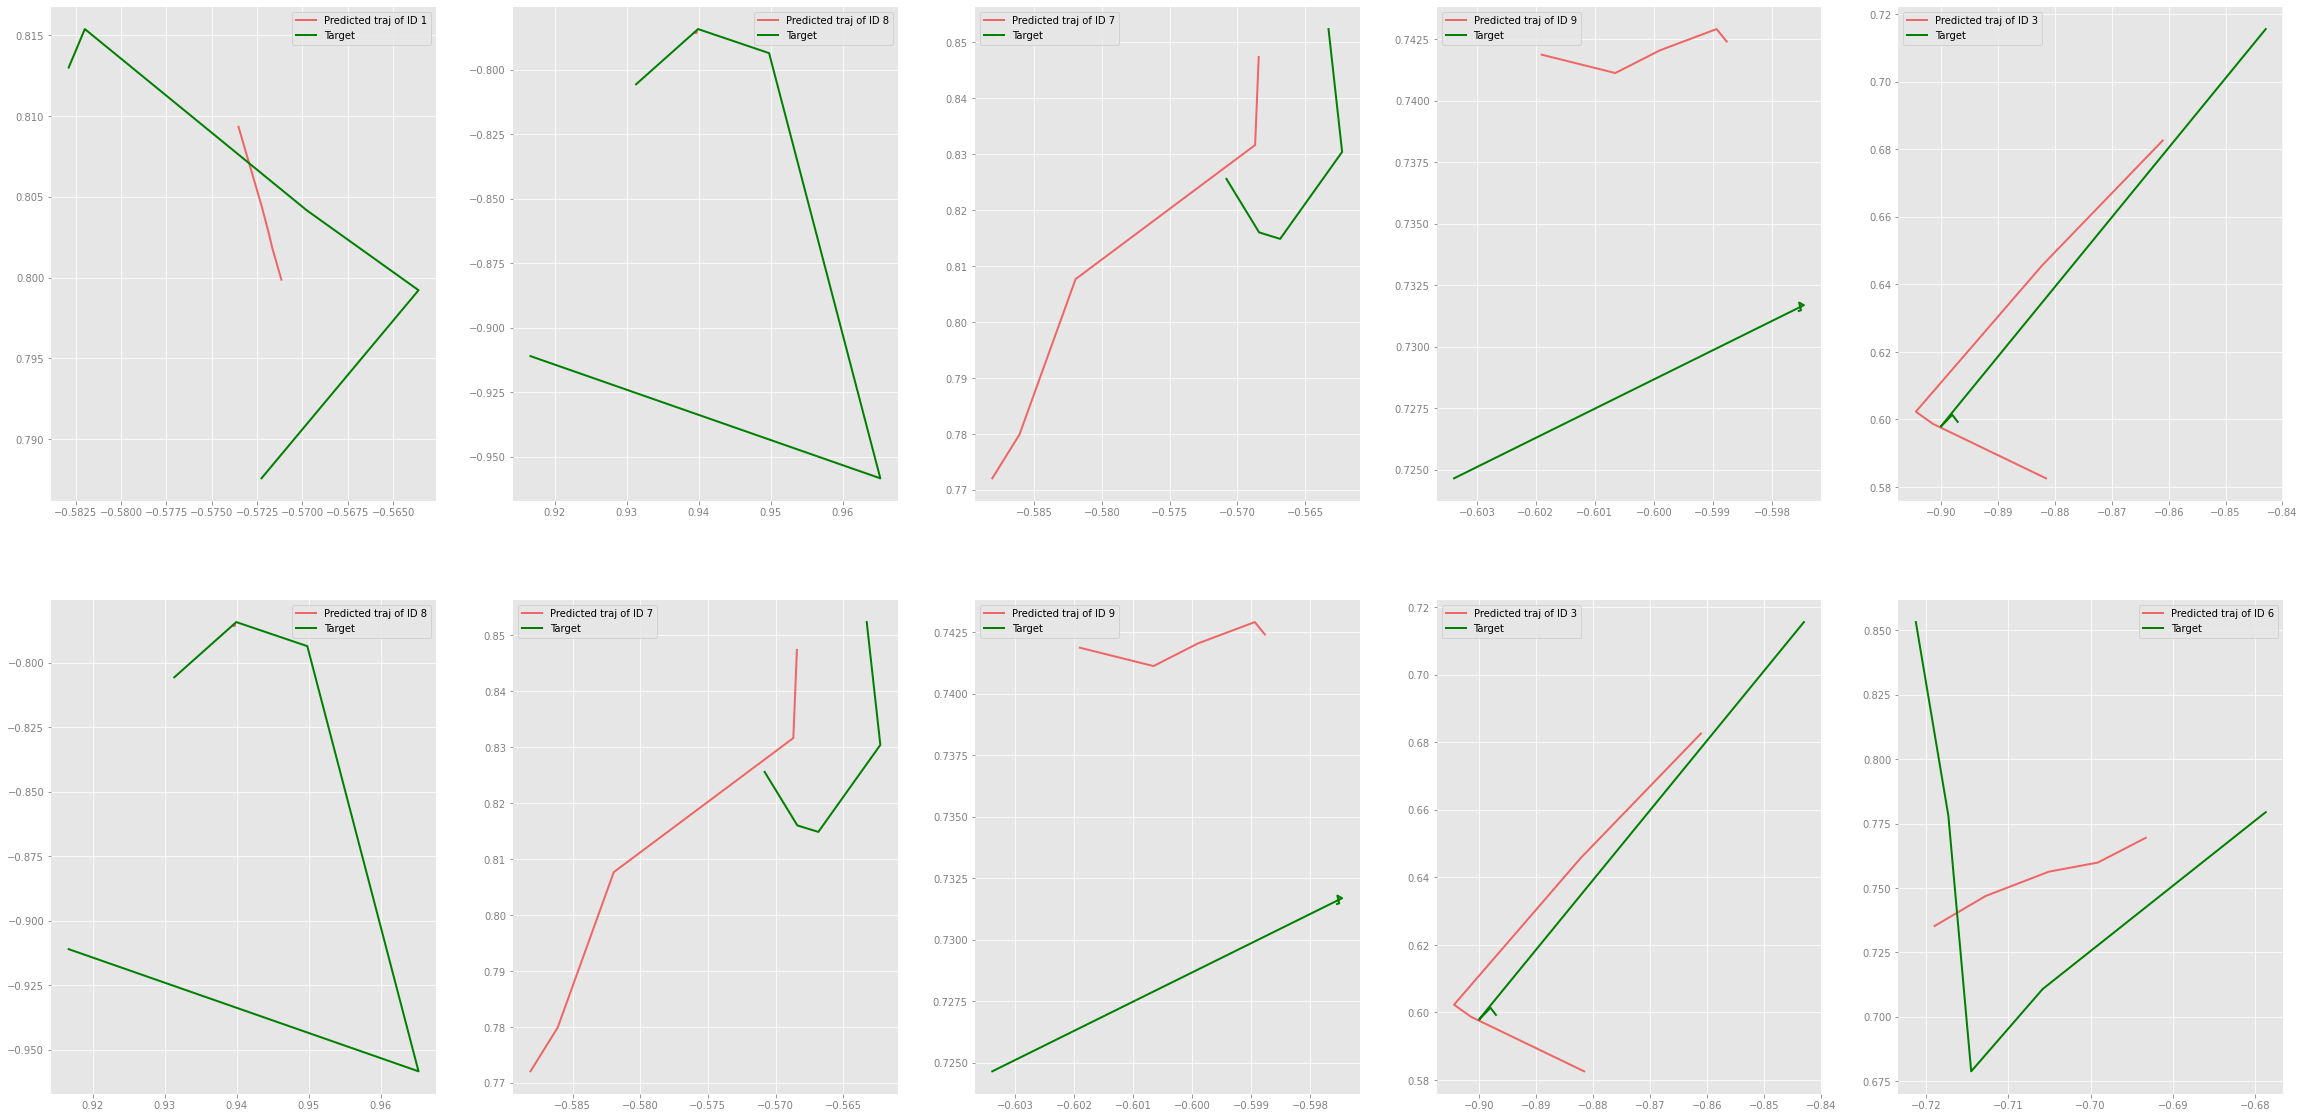

In [ ]:
### Plot predictions of a single trajectory
cat = category.detach().cpu().numpy().copy()

predicted_data_ = out.copy()
target_data_ = target.copy()
fig, ax = plt.subplots(nrows=2, ncols= 5, figsize=(16, 5), sharey=False)
# plt.ticklabel_format(useOffset=False)
fig.set_size_inches(40,20)
for i in range(2):
    for j in range(5):
        ax[i,j].plot(predicted_data_[:,0][(i+j)*num_future:(i+j)*num_future + num_future], 
                     predicted_data_[:,1][(i+j)*num_future:(i+j)*num_future+ num_future], 
                     label='Predicted traj of ID {}'.format(cat[i+j]))
        
        ax[i,j].plot(target_data_[:,0][(i+j)*num_future:(i+j)*num_future + num_future], 
                     target_data_[:,1][(i+j)*num_future:(i+j)*num_future+ num_future],label = 'Target',color='g')
        ax[i,j].legend()
        
        plt.autoscale(True,axis='y',tight=False)

plt.savefig('predictions2')
plt.show()

### Freely generate samples using Trained Decoder

In [ ]:
 # Generating few samples
batch_size = 10 # Number of samples
num_future = 10 # Number of time steps in each sample

# Noise
# z = torch.randn((batch_size, latent_size)).to(device)
z = torch.empty(10, latent_size).normal_(mean=0,std=.1).to(device)
# Category from the noise
cat = model.classifier(z)
# Generate trajectories from the noise
out = model.decoder(z,num_future).cpu().detach().numpy()
out = out.reshape(out.shape[0]*out.shape[1],out.shape[2])

# for index, i in enumerate(train_df.columns):
#     scaler = scalers['scaler_'+i]  
#     out[:,index] = scaler.inverse_transform(out[:,index].reshape(1, -1))
print('IDs in this batch of synthetic data',torch.max(cat,1).indices+1)
plt.figure(figsize=(12,4))
plt.plot(out[:,0], label='Generated x: Longitude')
plt.plot(out[:,1], label='Generated y: Latitude')
plt.legend()

fig, ax = plt.subplots(nrows=2, ncols= 5, figsize=(16, 5), sharey=True)
# plt.ticklabel_format(useOffset=False)
fig.set_size_inches(20,5)
for i in range(2):
    for j in range(5):
        ax[i,j].plot(out[:,0][(i+j)*num_future:(i+j)*num_future + num_future],out[:,1][(i+j)*num_future:(i+j)*num_future+ num_future],label = 'Animal ID {}'.format((torch.max(cat,1).indices+1).detach()[i+j]),color='g')
        ax[i,j].legend()
plt.show()
 